TODO:

PCA/feature selection

Removing outliers

Streamlining analysis with scikit

Adding also tensorflow/keras


In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys


In [51]:
def plot_categorical(grouped,label,figsize=(12,8)):
    plt.figure(figsize=figsize)
    labels=[]
    data=[]
    for name,group in grouped:
        labels.append(name)
        data.append(group[label])
    plt.boxplot(data,labels=labels)
    plt.xlabel(name)
    plt.ylabel(label)
    plt.show()

Feature engineering function:

In [52]:
from house_prices import feat_eng

# Real estate price prediction

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Notes: lots of columns -> possible PCA? (see ml-basic-> clustering tutorial for info on PCA with sklearn)

In [53]:
train,test=pd.read_csv('train.csv'),pd.read_csv('test.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [54]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [55]:
train,test=feat_eng(train),feat_eng(test)

In [56]:
count=test.isna().sum()
count=pd.DataFrame(count)
count[count[0]!=0]

,0
MSZoning,4
LotFrontage,227
Alley,1352
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,16
MasVnrArea,15
BsmtQual,44
BsmtCond,45


In [57]:
features=test.keys()
print(features)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [58]:
len(features)

83

In [59]:
label='SalePrice'

#### Plotting raw features

In [60]:
plot=True


In [61]:
def plot_synth_f(df:pd.DataFrame,plot_type='s',sf='synth',label='SalePrice'):
    #definition of synthetic feature here
    df[sf]=df['TotFlrSF']#how do I pass a function on the dataframe?
    if plot_type=='c':
        grouped=df.groupby(sf)
        plot_categorical(grouped)
    else:
        plt.scatter(df[sf],df[label])
        plt.xlabel(sf)
        plt.ylabel(label)
        z = np.polyfit(df[sf],df[label], 1)
        p = np.poly1d(z)
        plt.plot(df[sf],p(df[sf]), color='magenta')

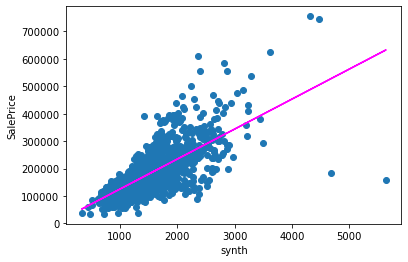

In [62]:
plot_synth_f(train)

Id 0


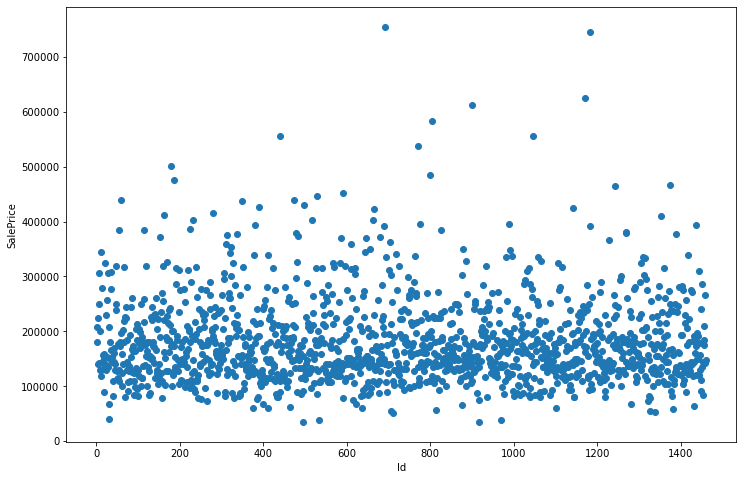

MSSubClass 1


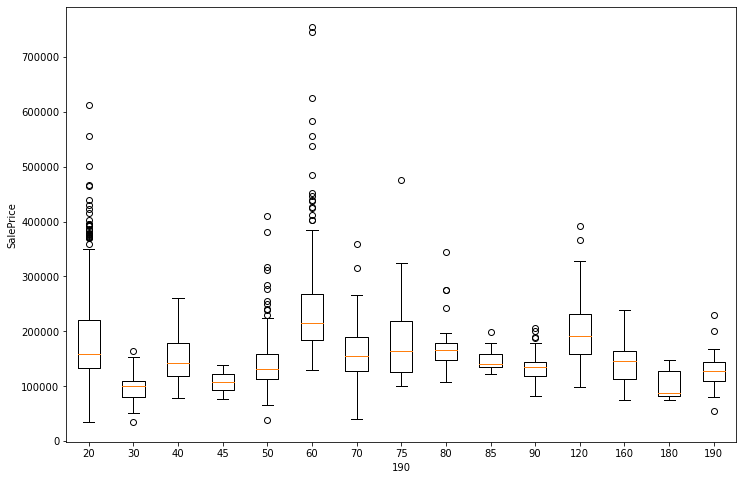

MSZoning 2


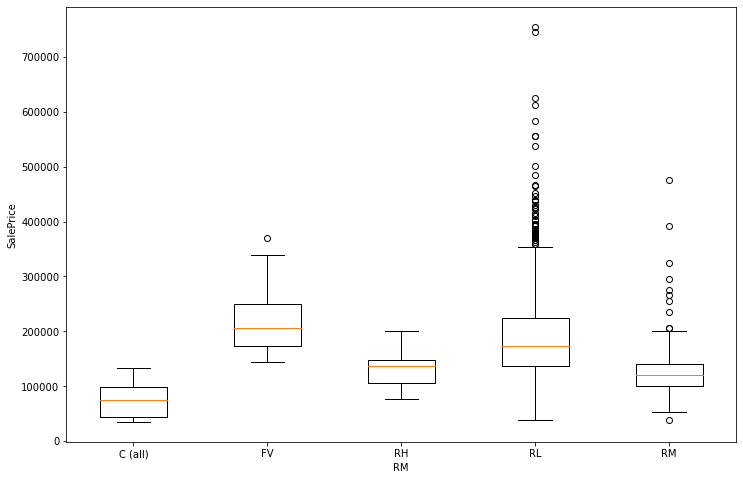

LotFrontage 3


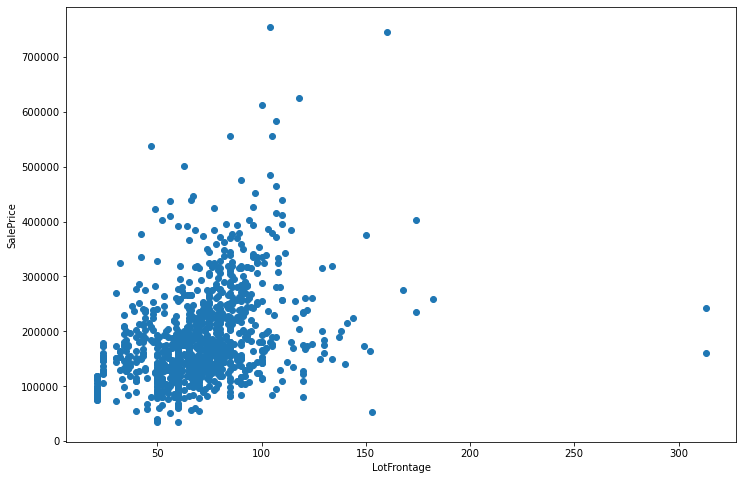

LotArea 4


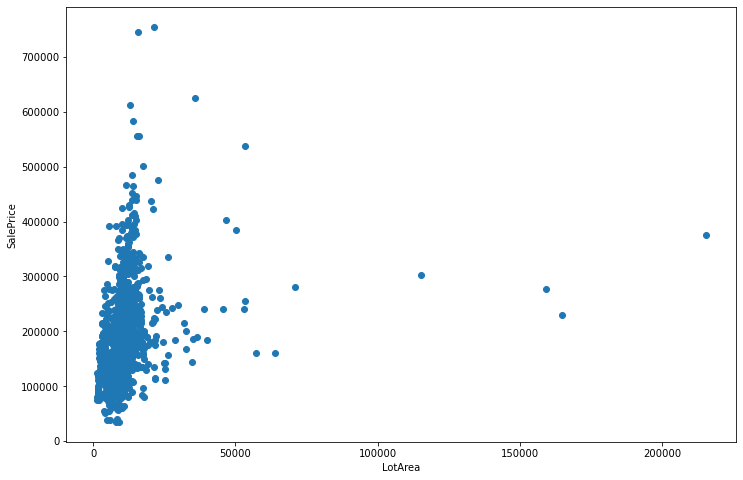

Street 5


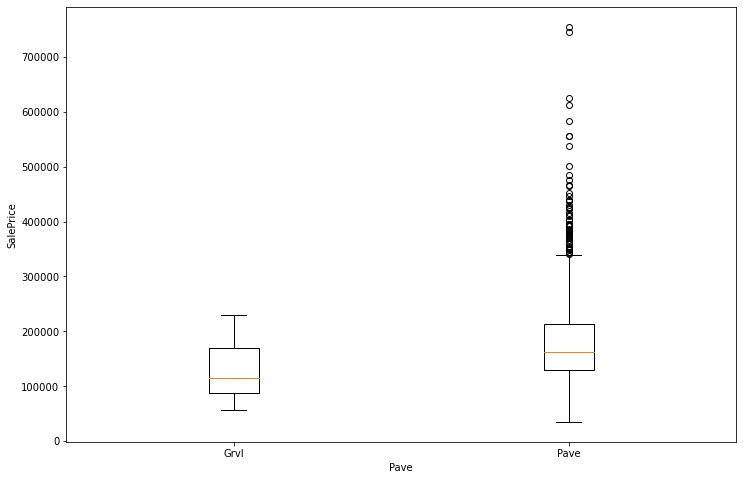

Alley 6


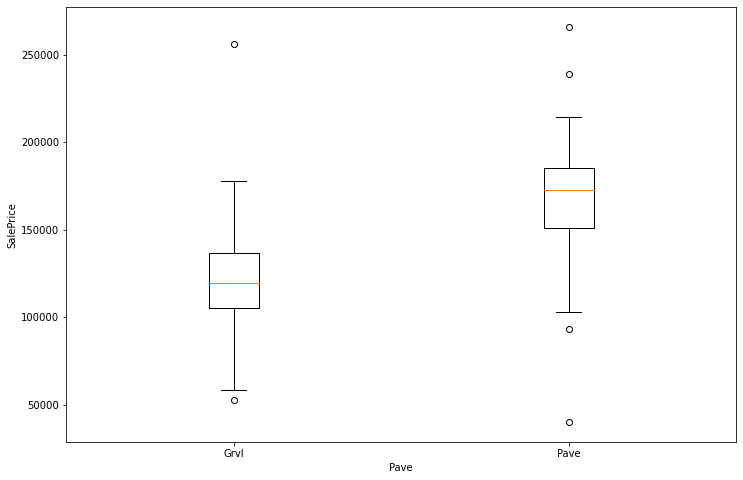

LotShape 7


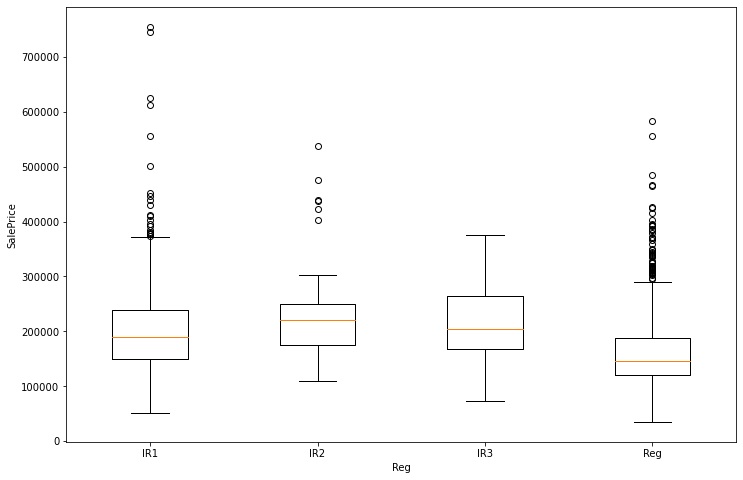

LandContour 8


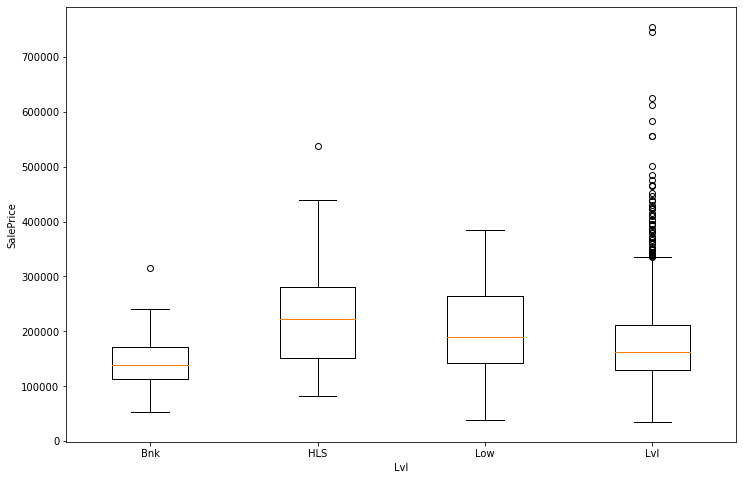

Utilities 9


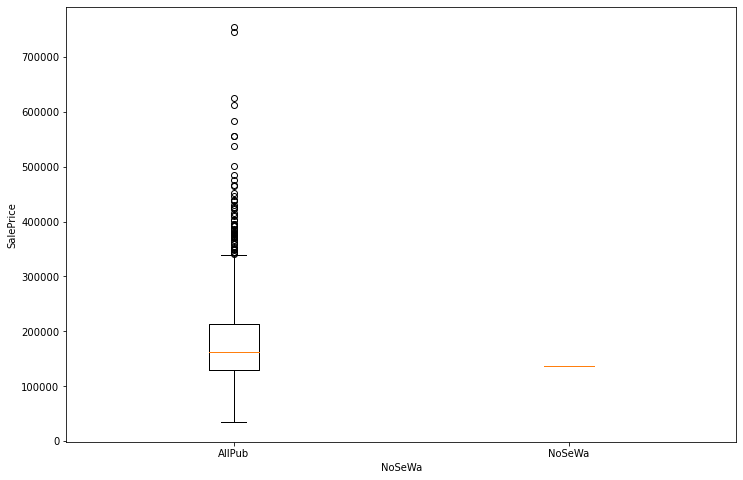

LotConfig 10


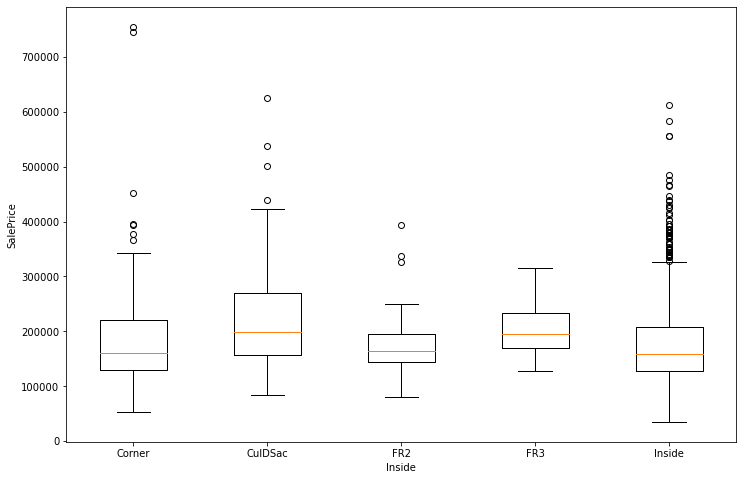

LandSlope 11


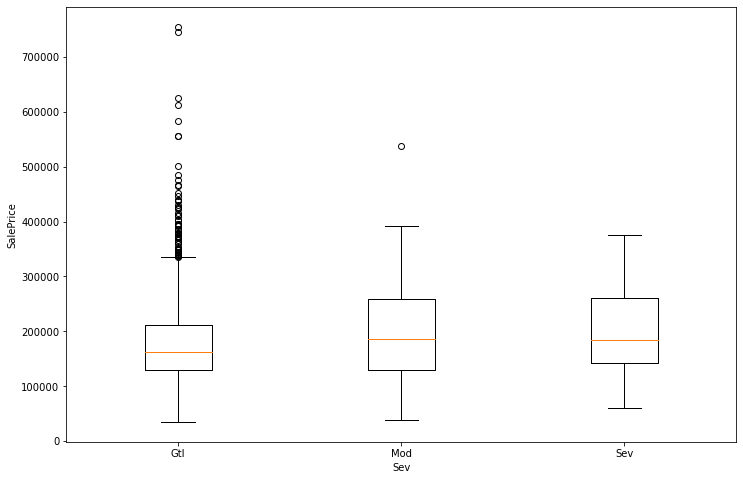

Neighborhood 12


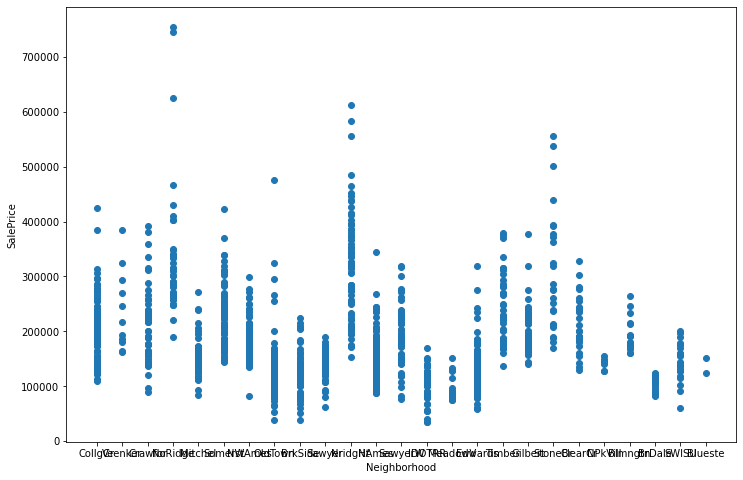

Condition1 13


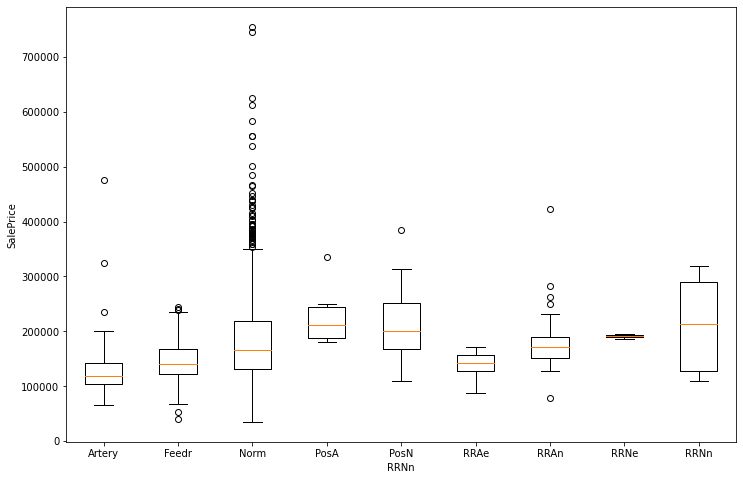

Condition2 14


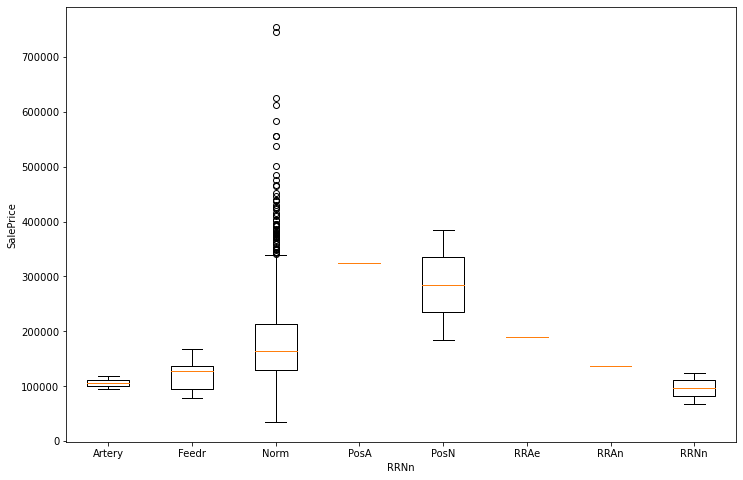

BldgType 15


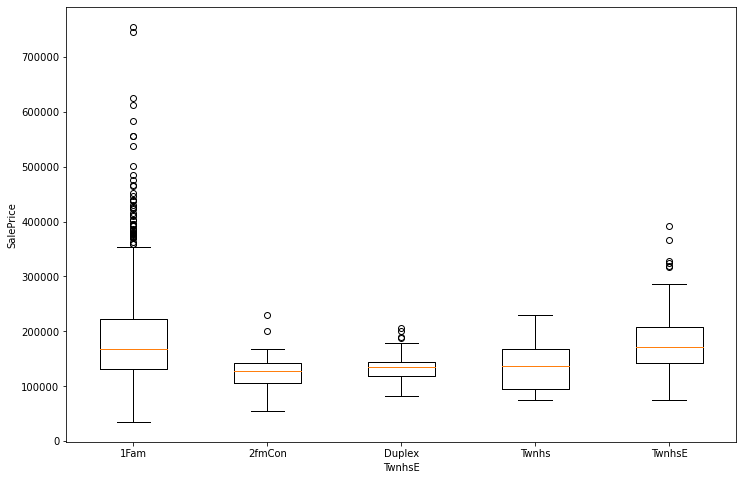

HouseStyle 16


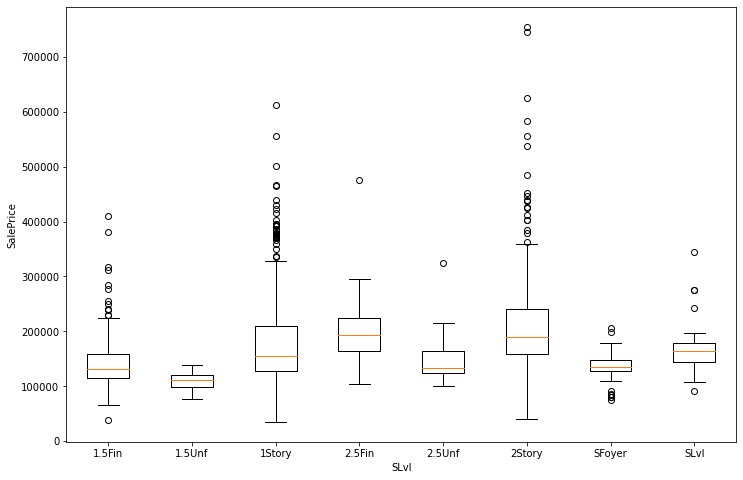

OverallQual 17


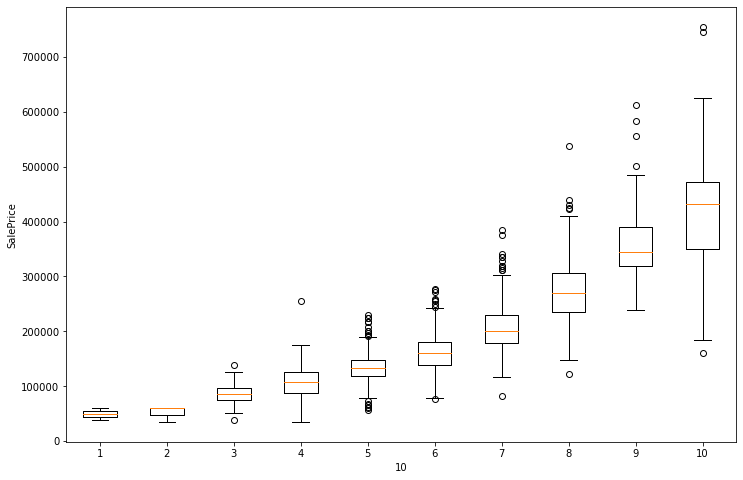

OverallCond 18


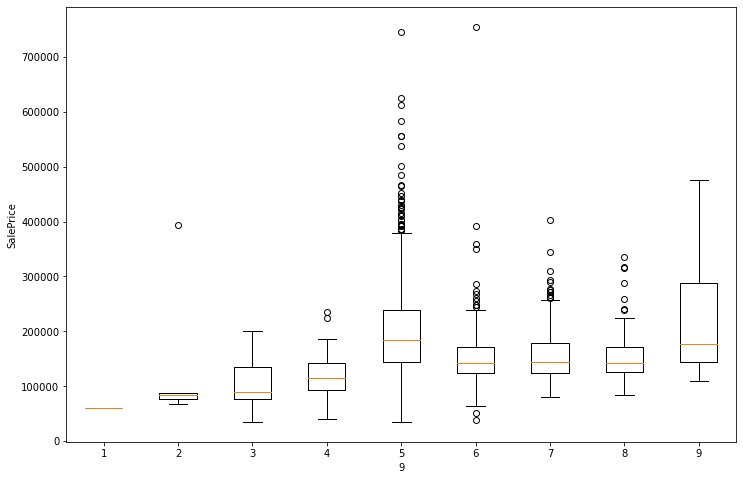

YearBuilt 19


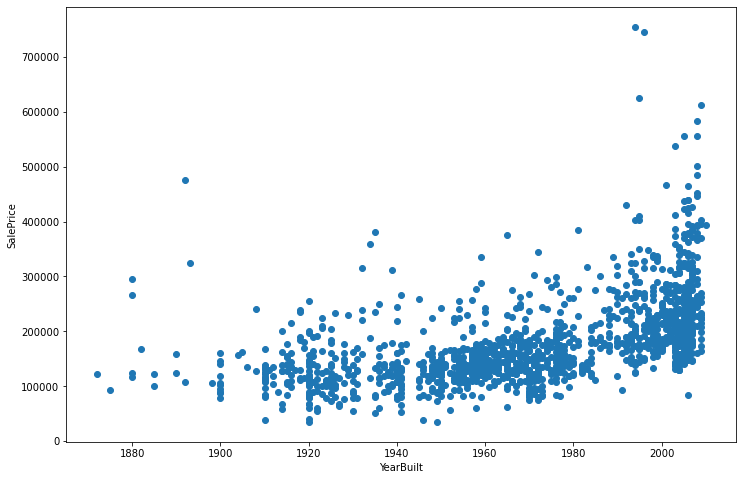

YearRemodAdd 20


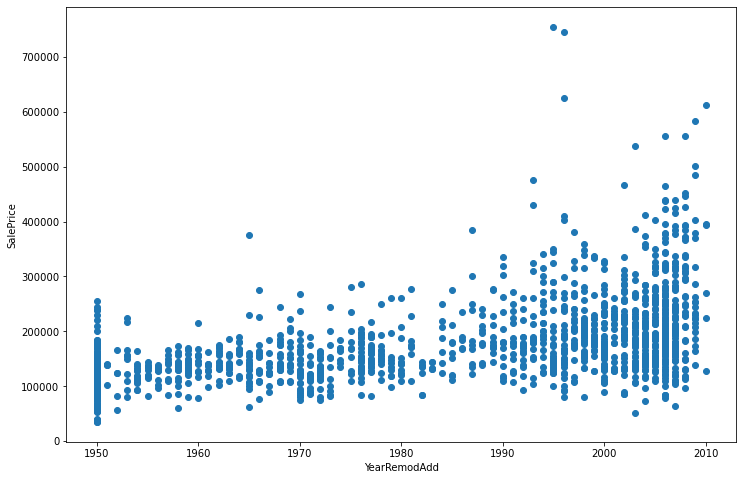

RoofStyle 21


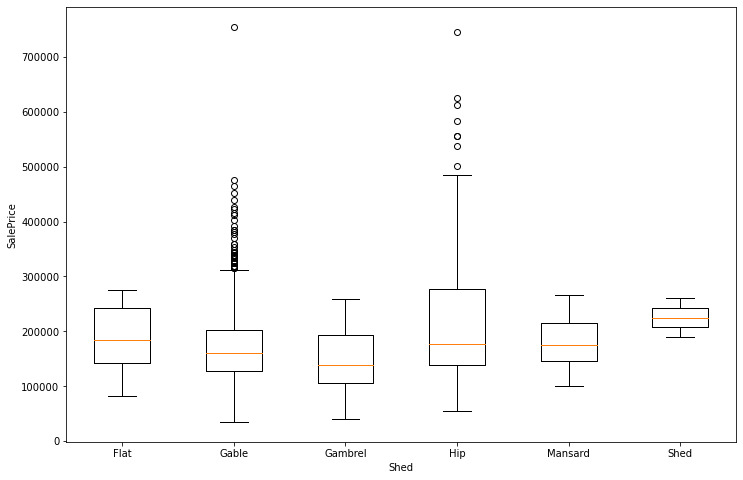

RoofMatl 22


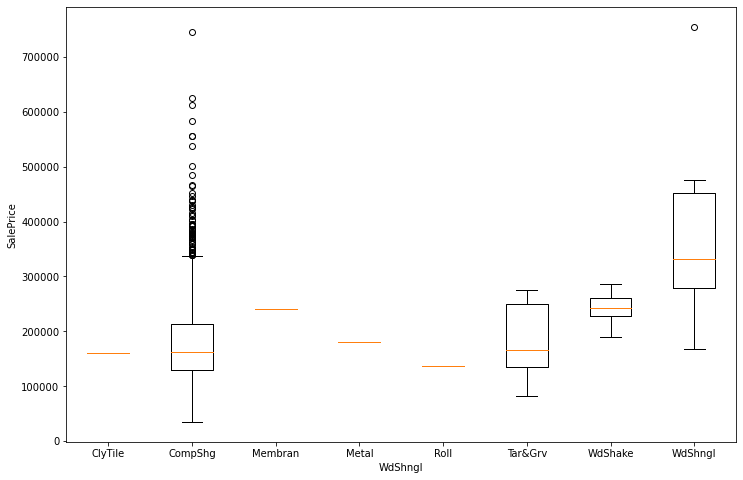

Exterior1st 23


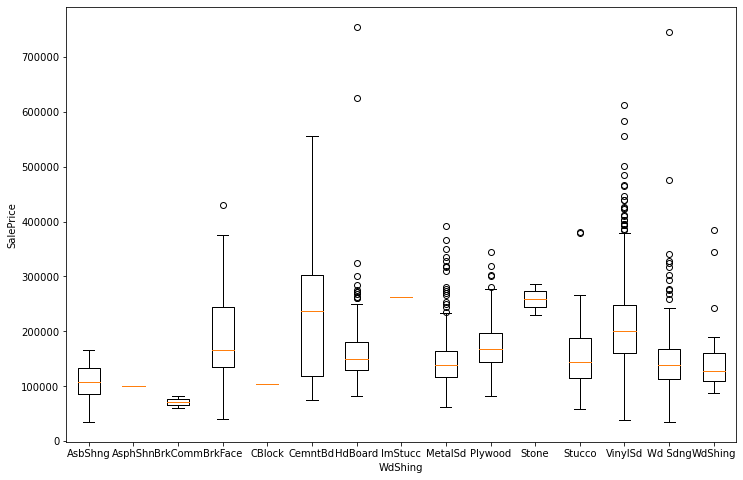

Exterior2nd 24


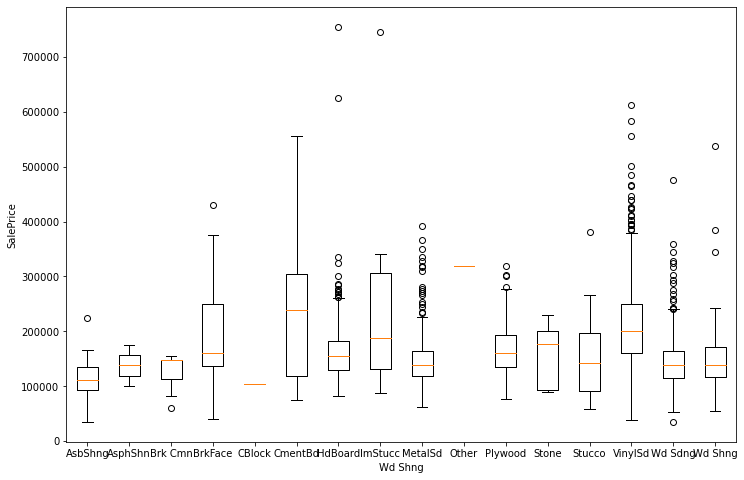

MasVnrType 25


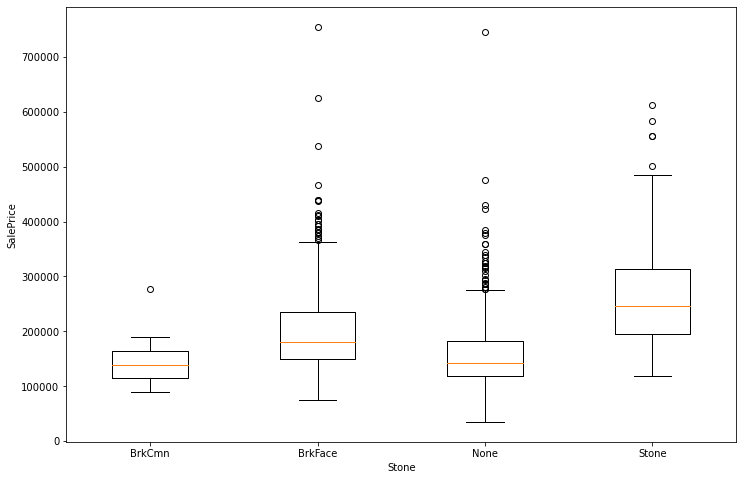

MasVnrArea 26


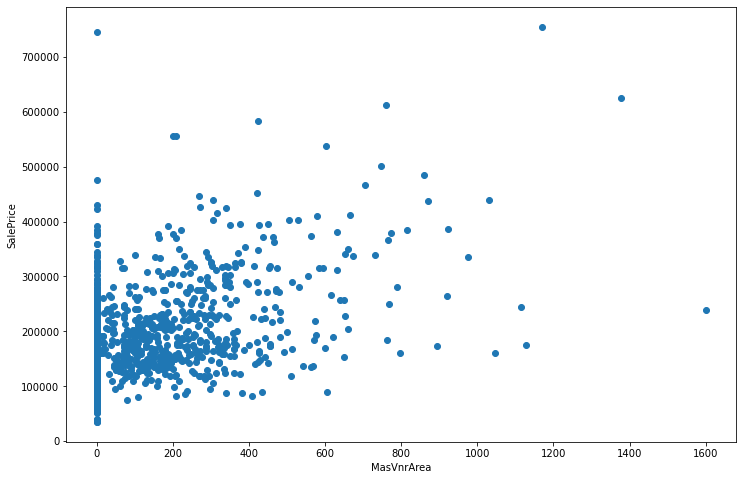

ExterQual 27


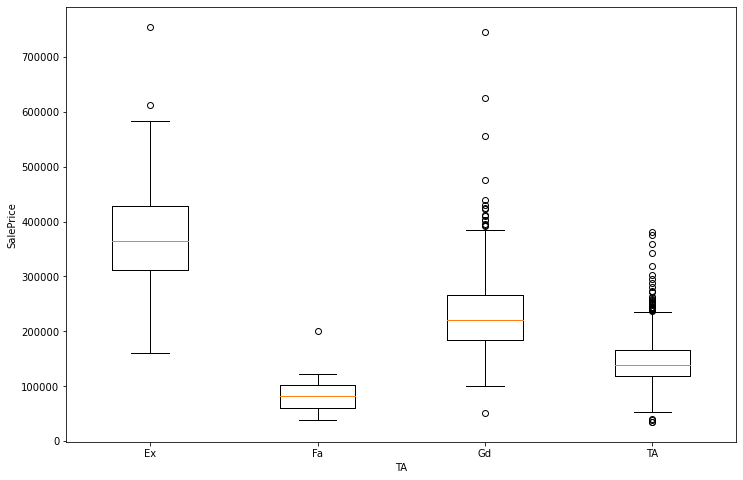

ExterCond 28


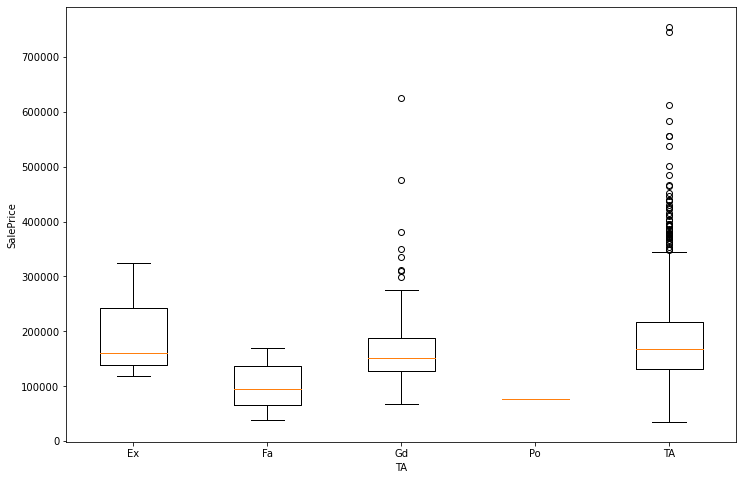

Foundation 29


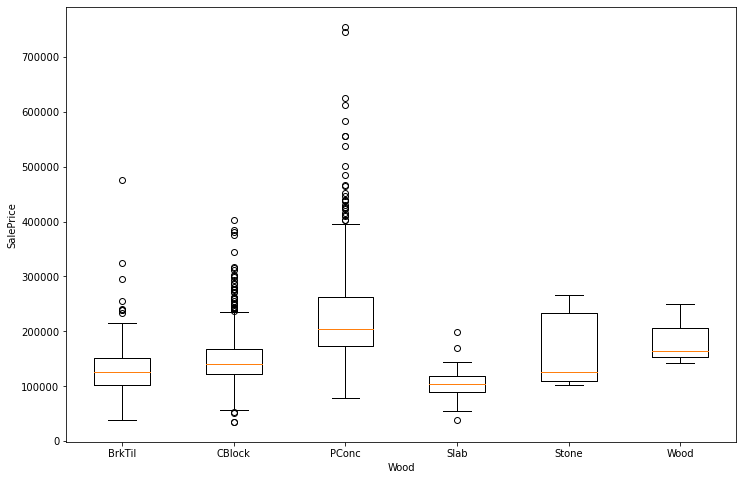

BsmtQual 30


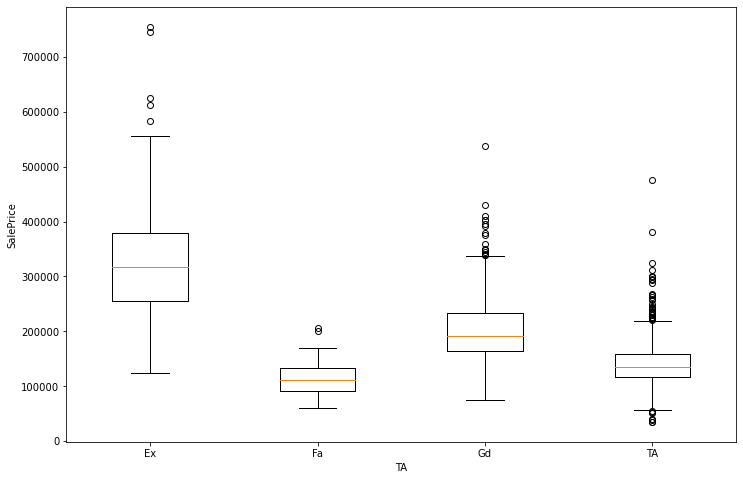

BsmtCond 31


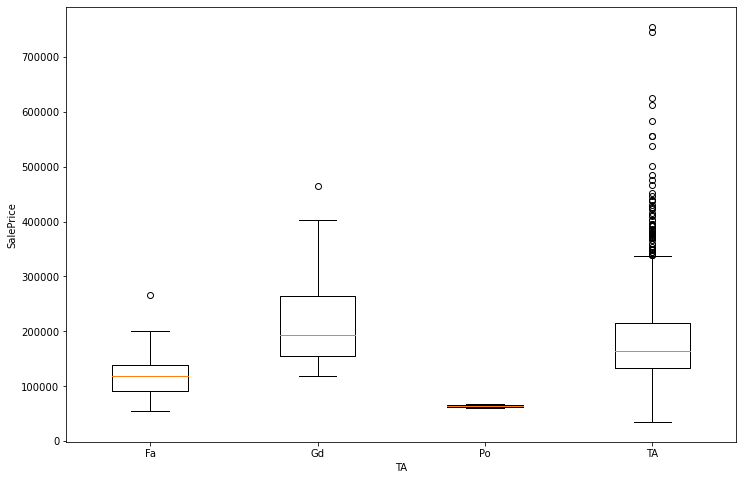

BsmtExposure 32


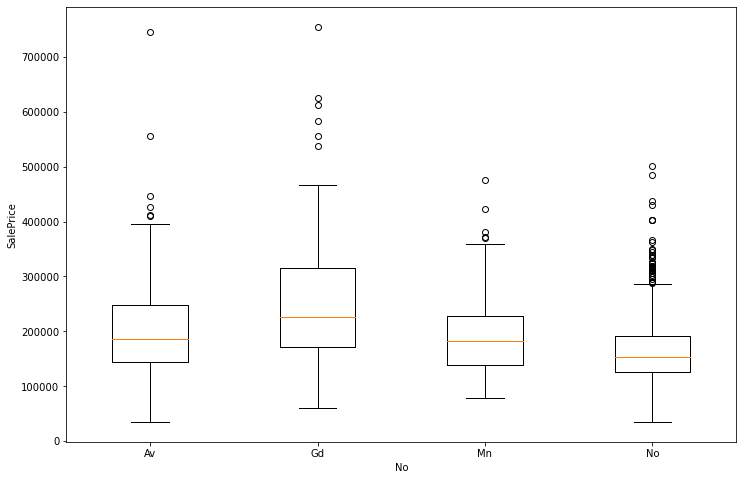

BsmtFinType1 33


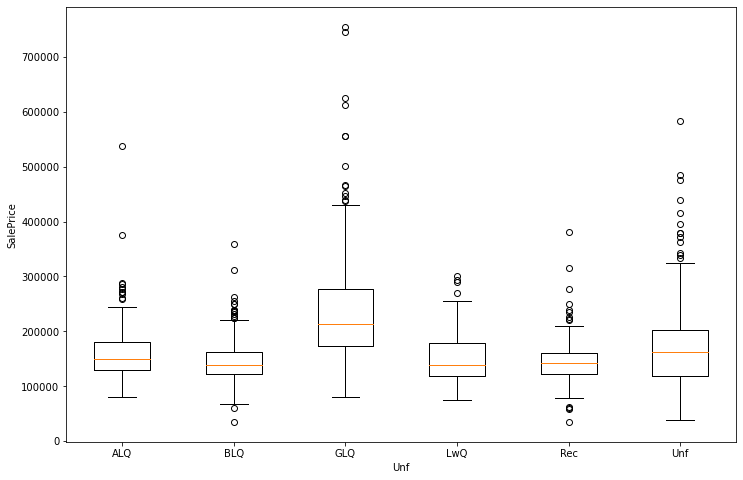

BsmtFinSF1 34


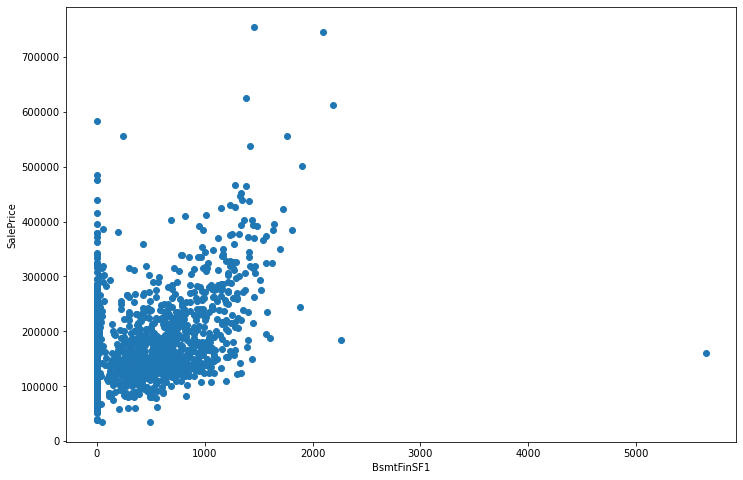

BsmtFinType2 35


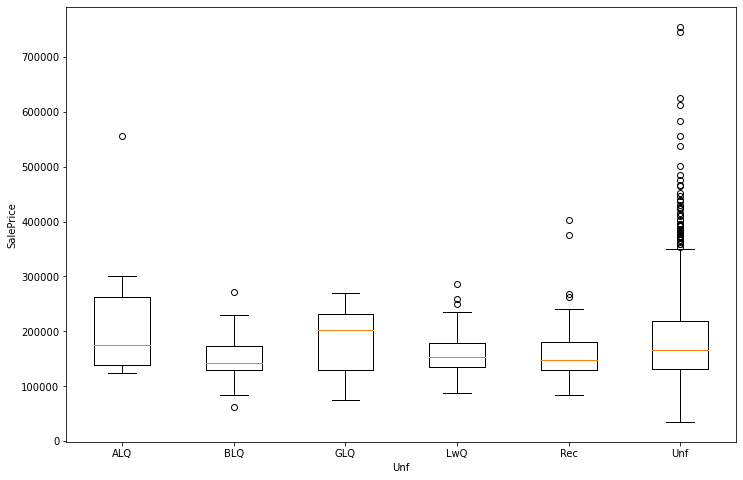

BsmtFinSF2 36


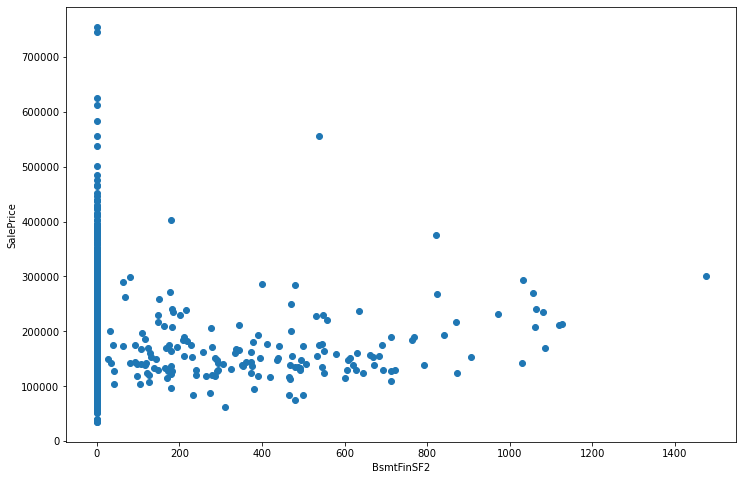

BsmtUnfSF 37


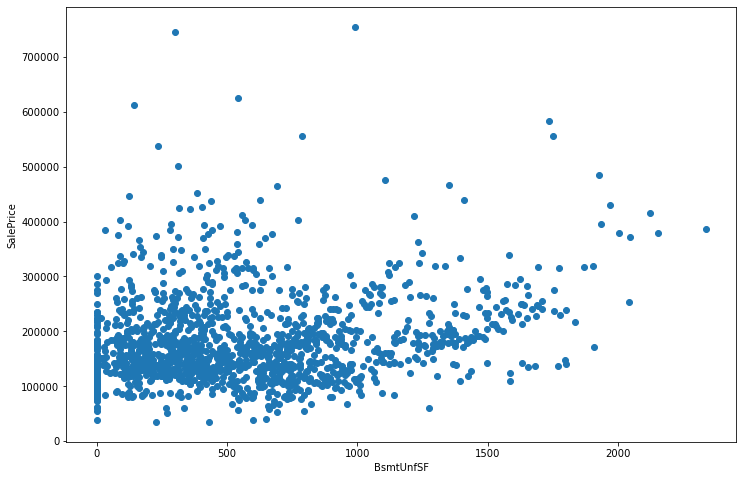

TotalBsmtSF 38


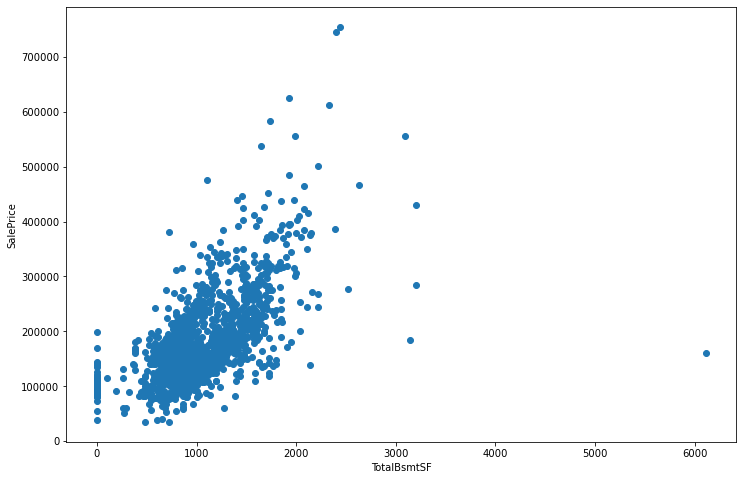

Heating 39


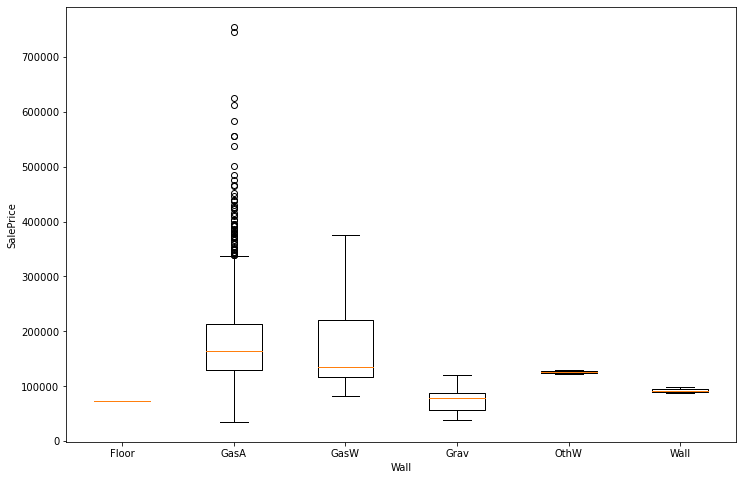

HeatingQC 40


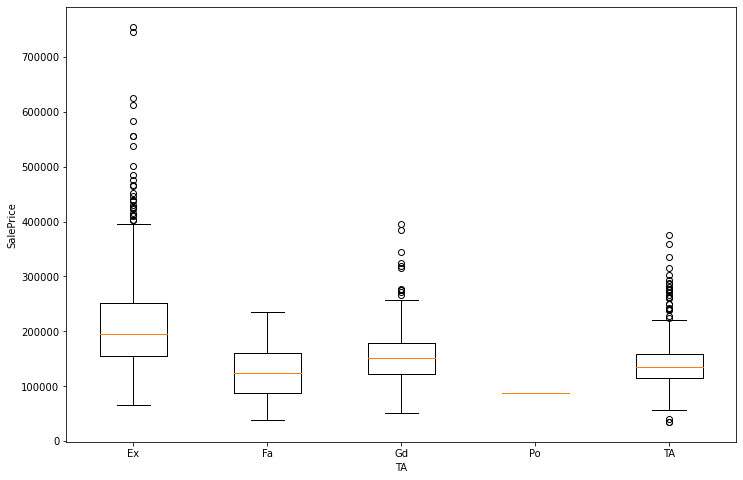

CentralAir 41


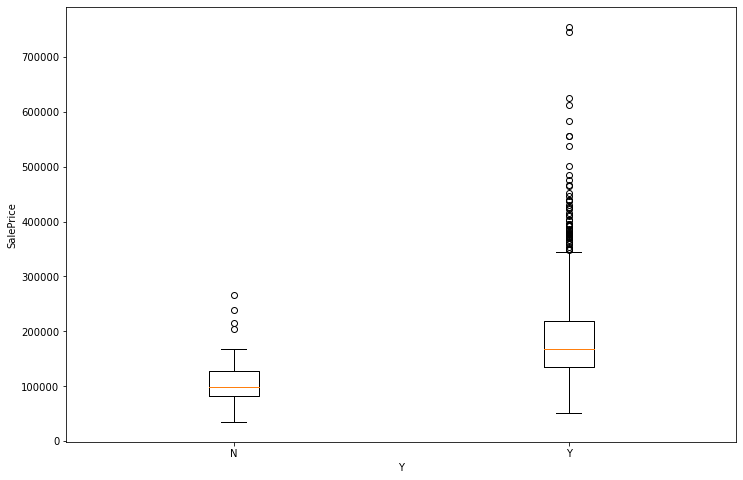

Electrical 42


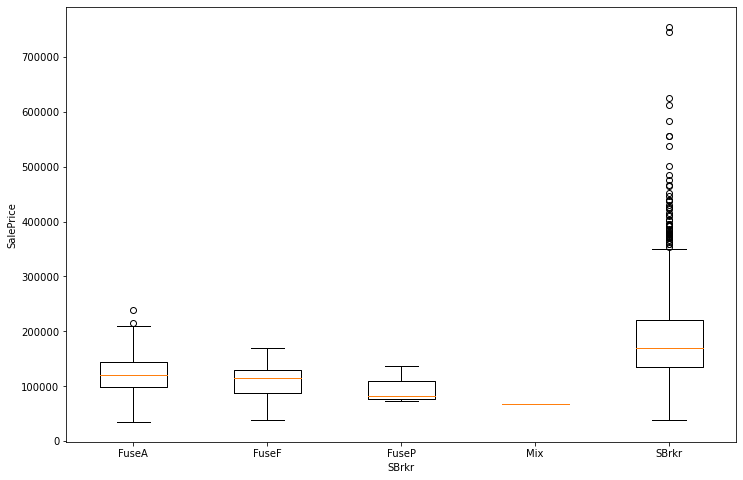

1stFlrSF 43


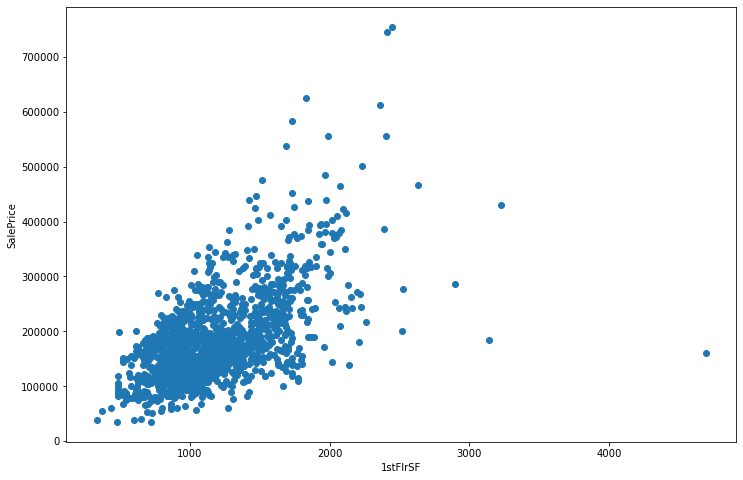

2ndFlrSF 44


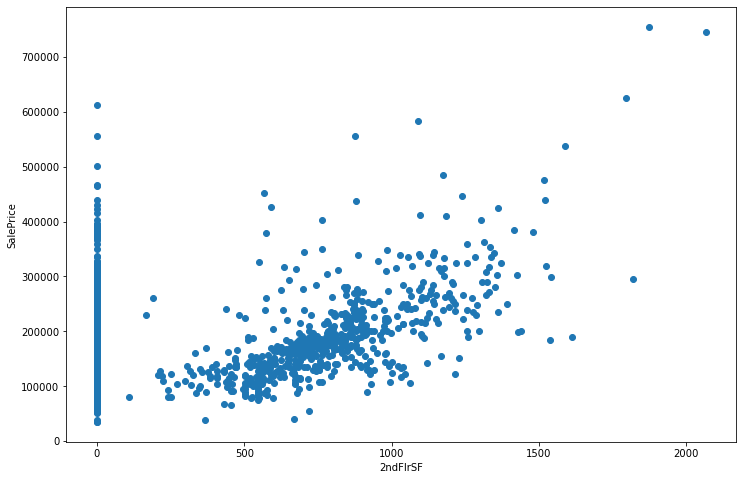

LowQualFinSF 45


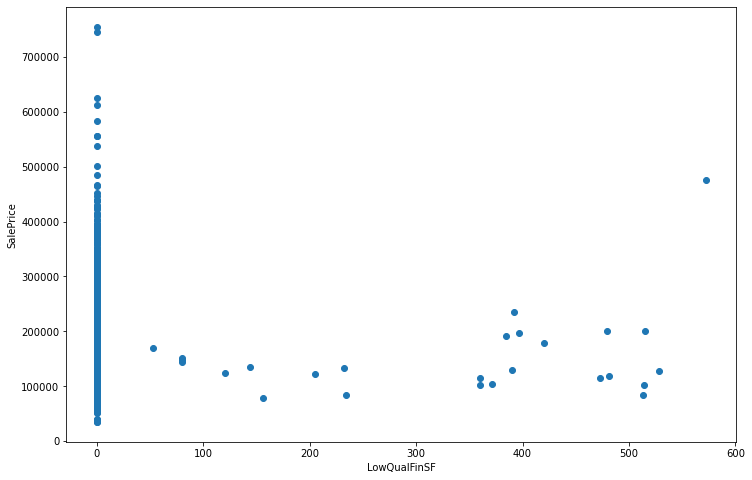

GrLivArea 46


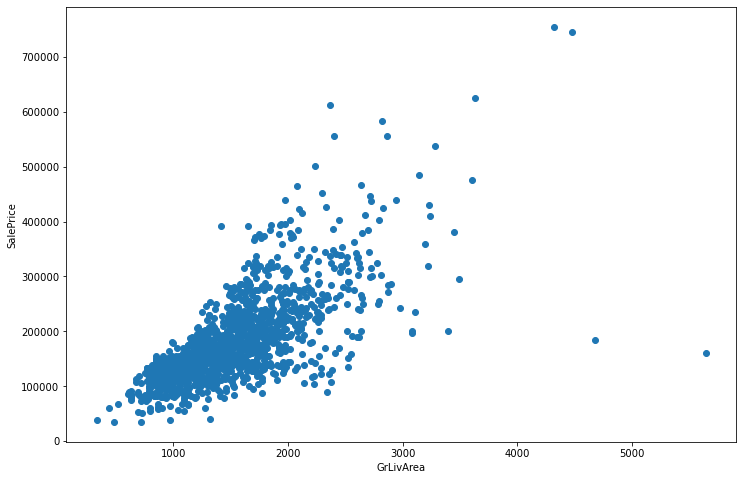

BsmtFullBath 47


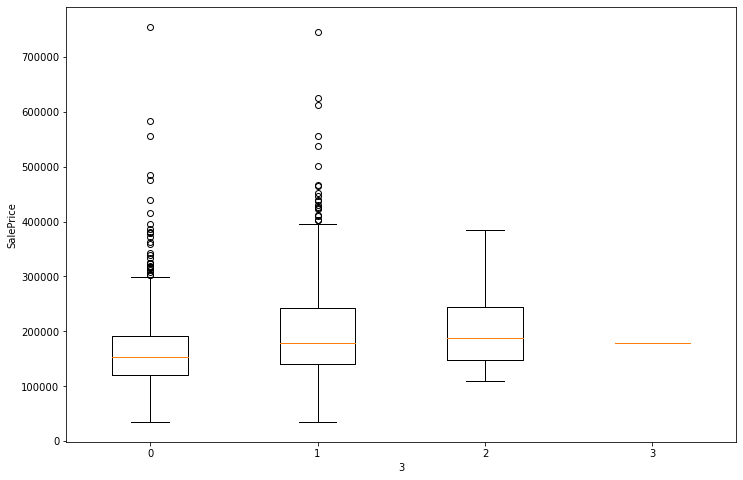

BsmtHalfBath 48


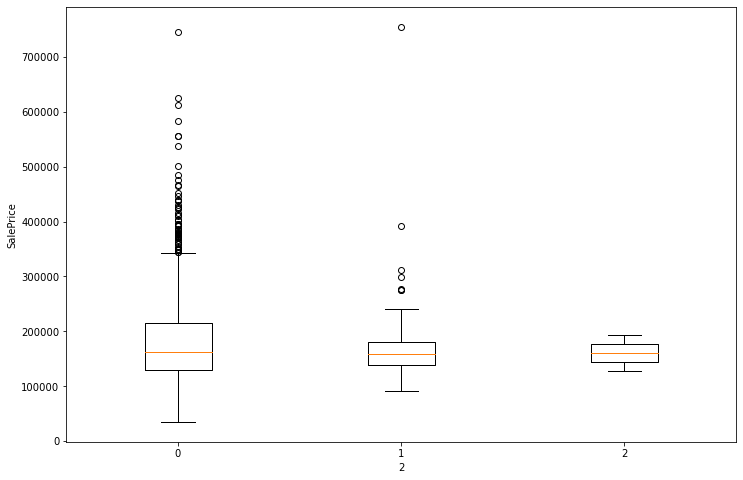

FullBath 49


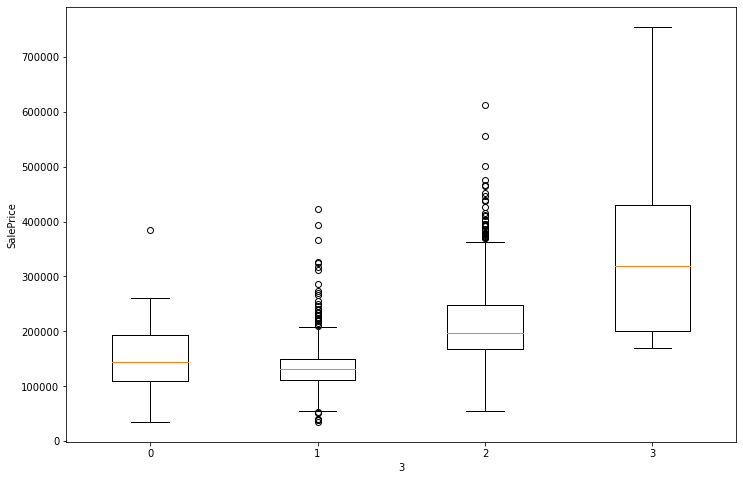

HalfBath 50


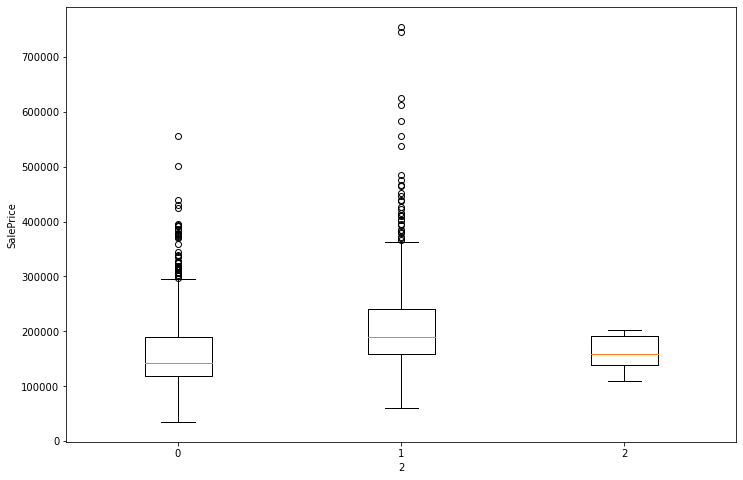

BedroomAbvGr 51


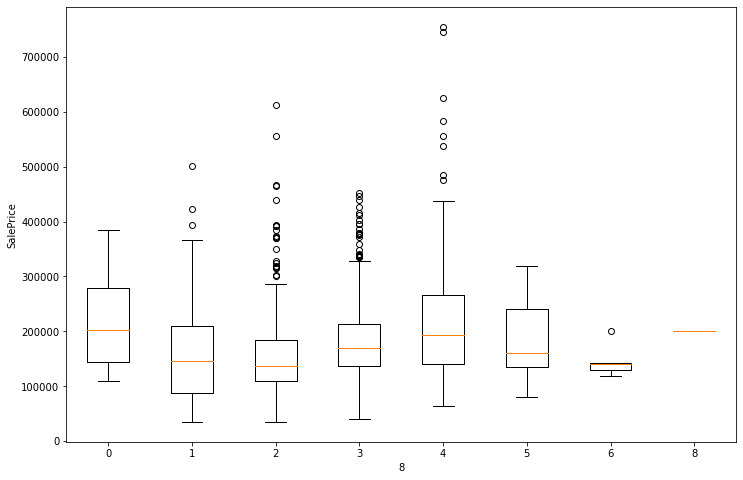

KitchenAbvGr 52


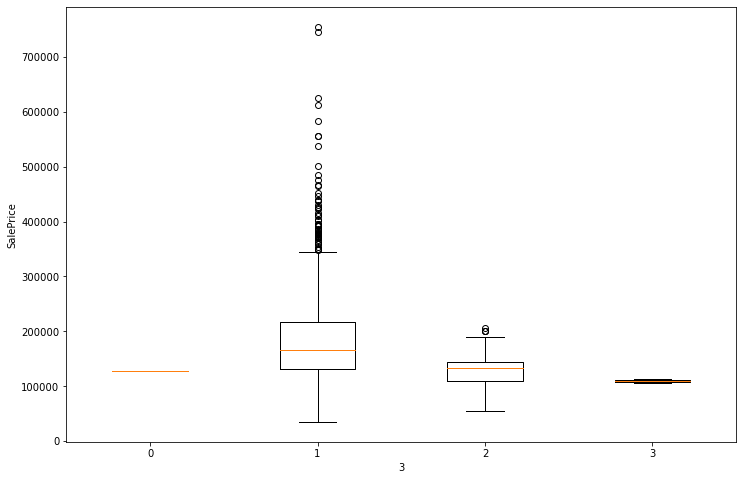

KitchenQual 53


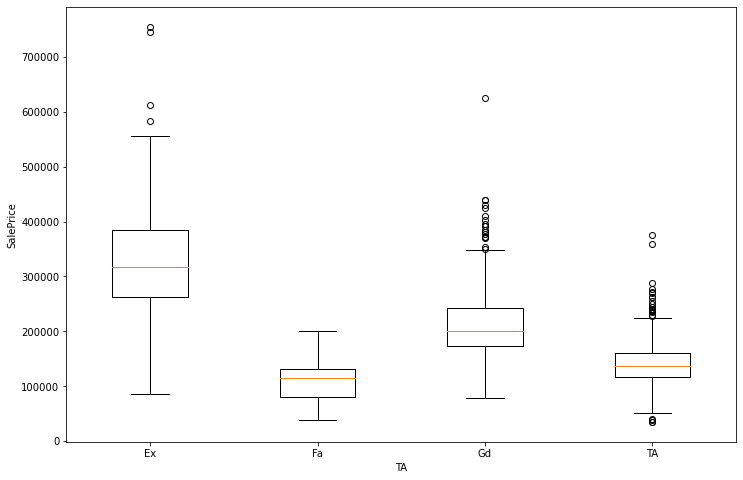

TotRmsAbvGrd 54


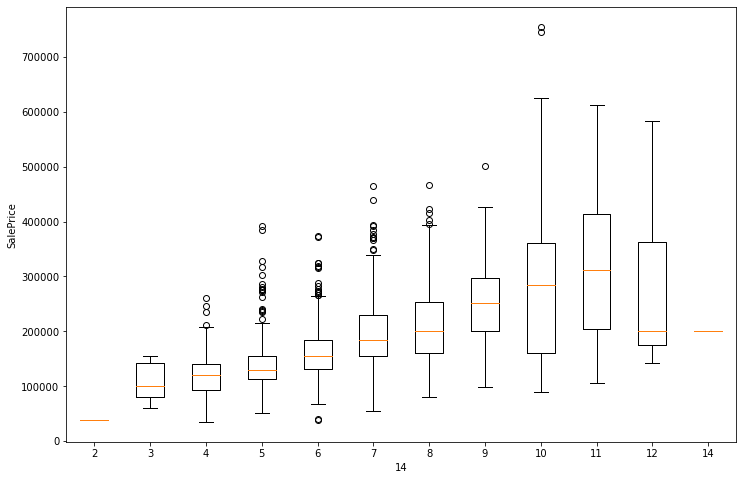

Functional 55


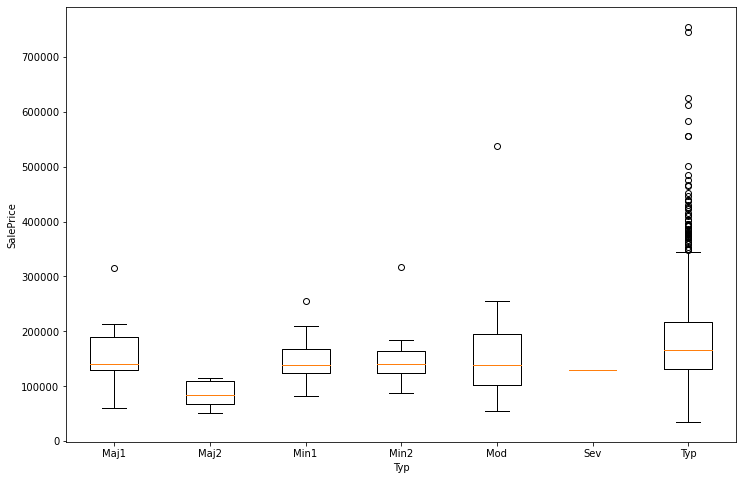

Fireplaces 56


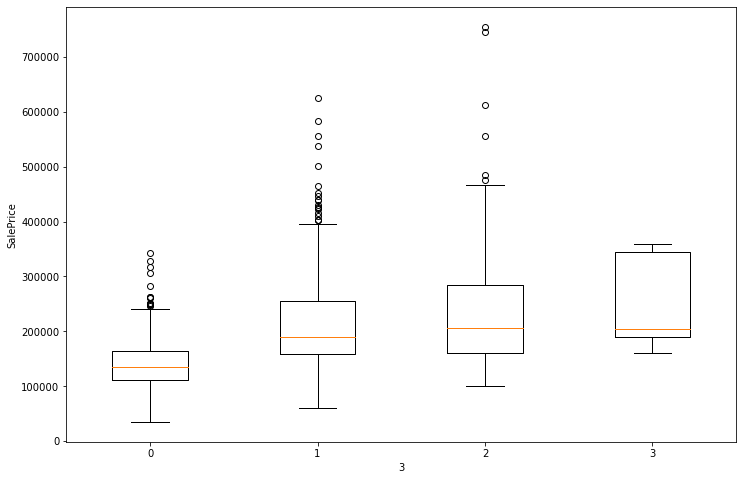

FireplaceQu 57


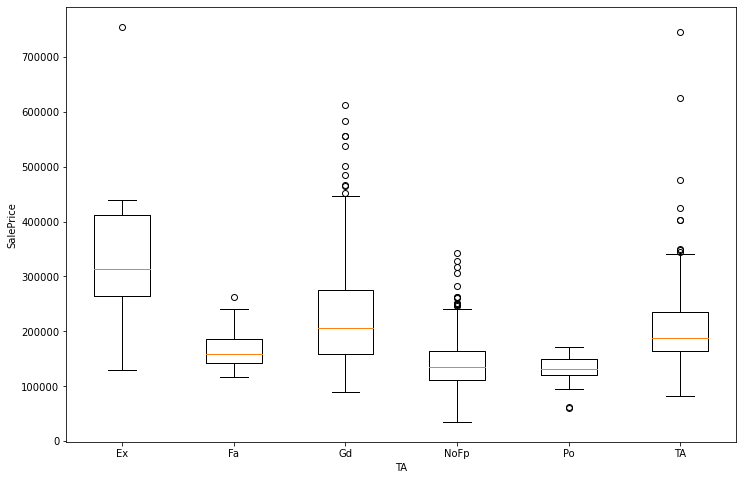

GarageType 58


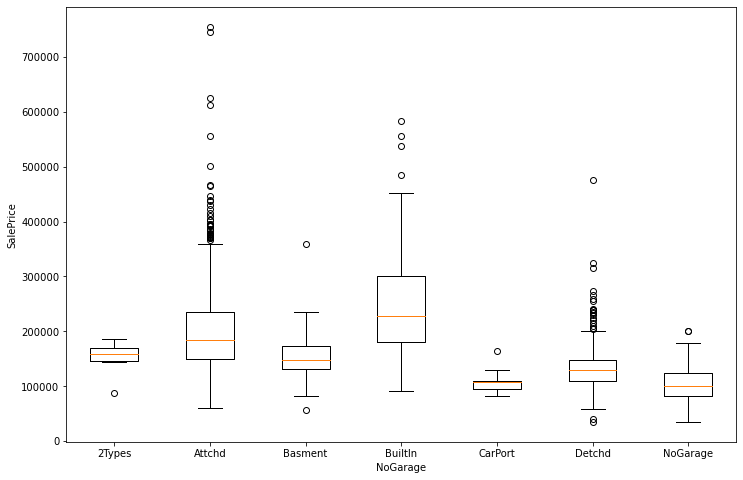

GarageYrBlt 59


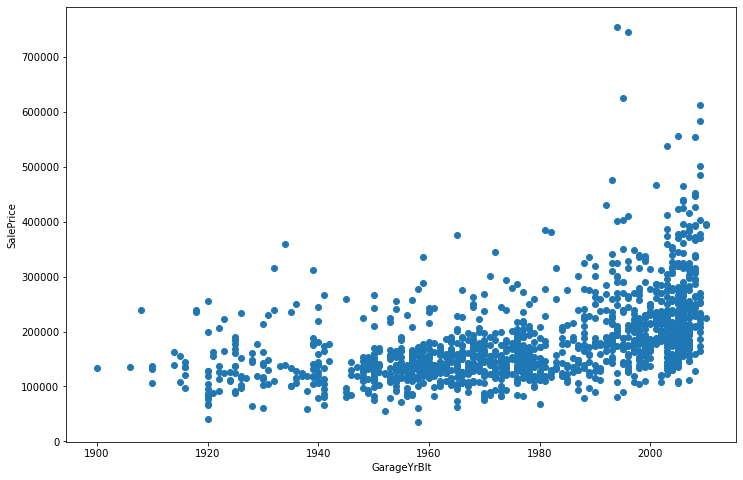

GarageFinish 60


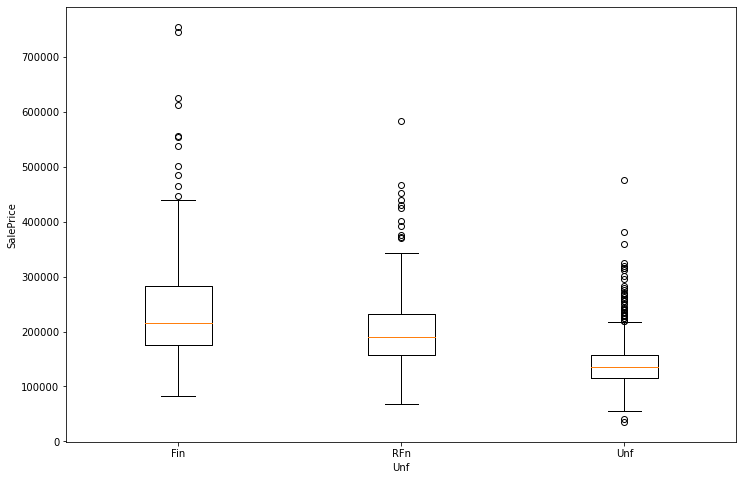

GarageCars 61


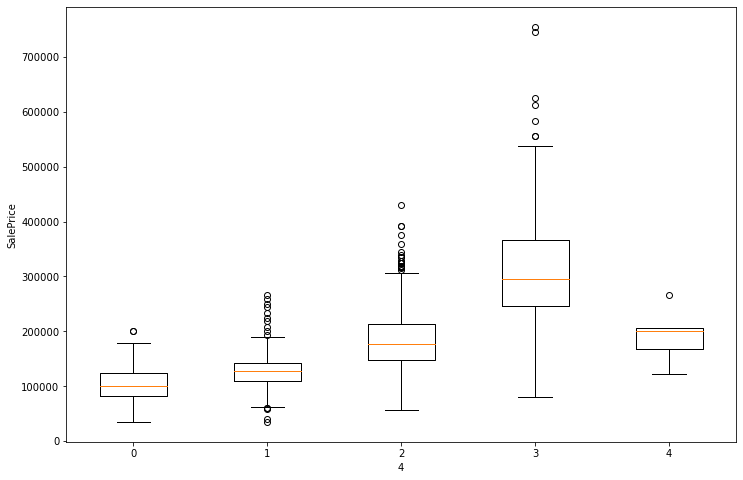

GarageArea 62


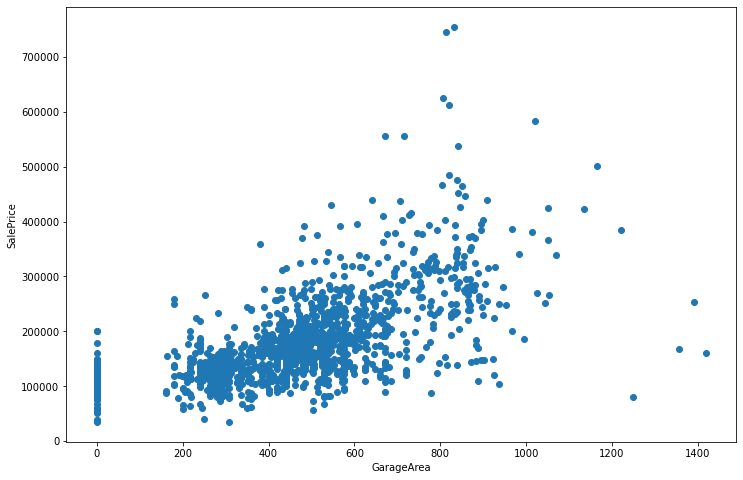

GarageQual 63


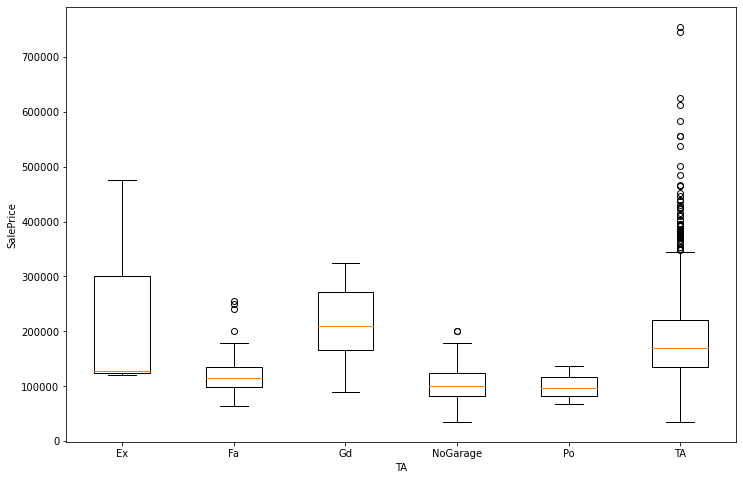

GarageCond 64


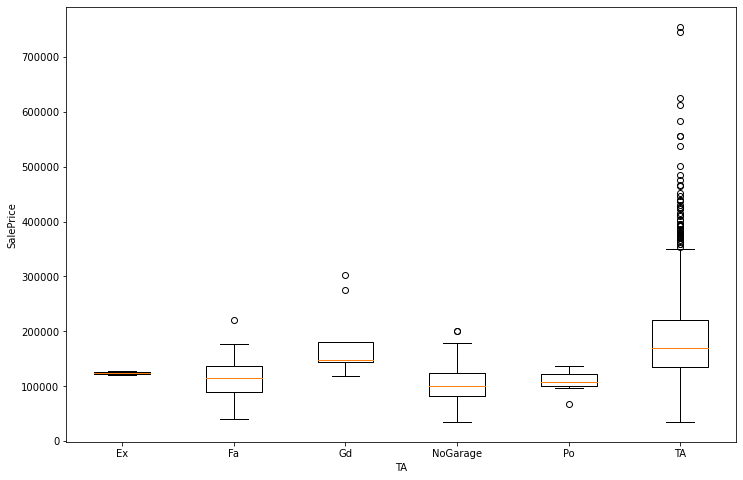

PavedDrive 65


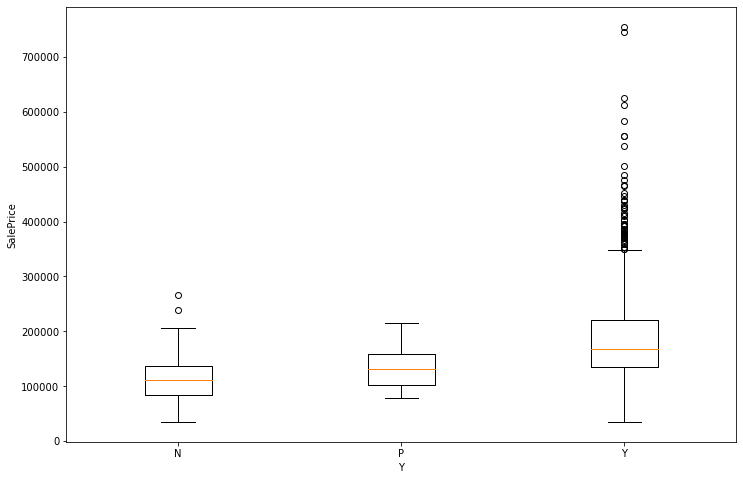

WoodDeckSF 66


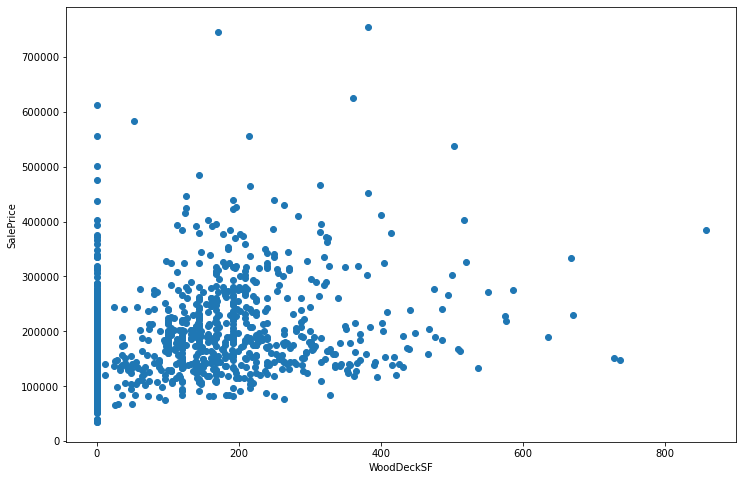

OpenPorchSF 67


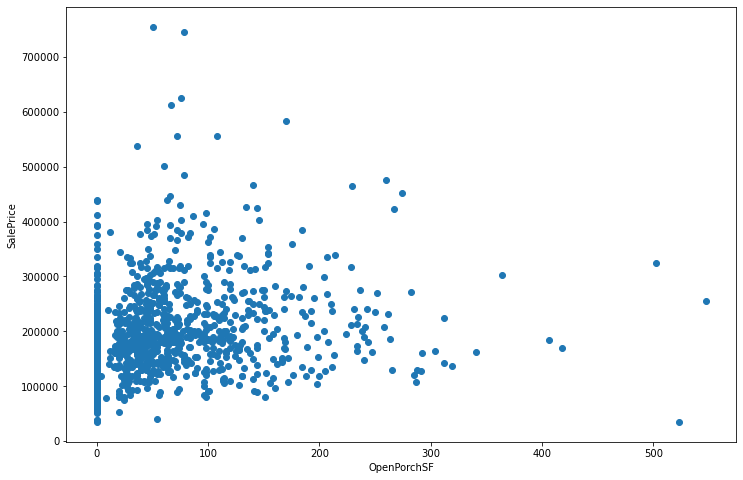

EnclosedPorch 68


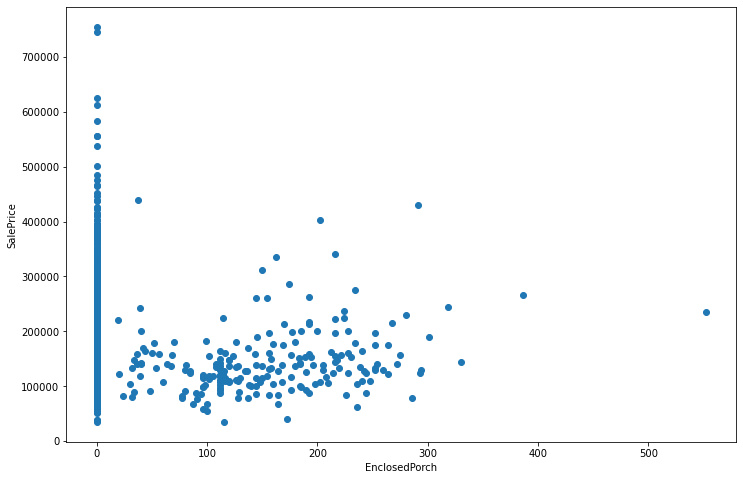

3SsnPorch 69


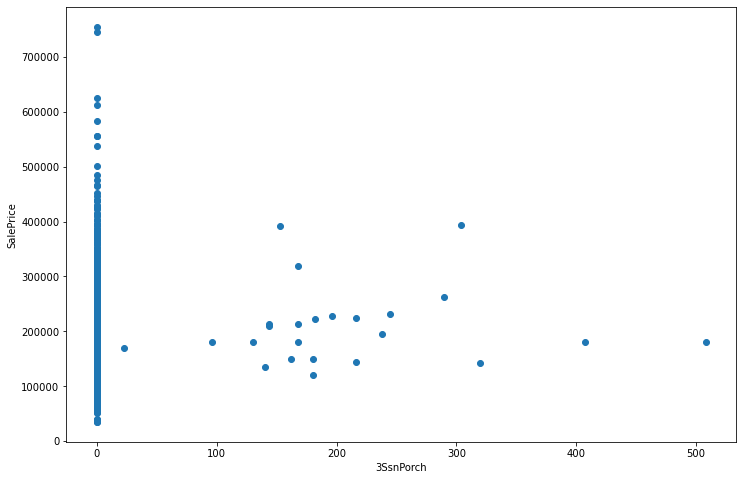

ScreenPorch 70


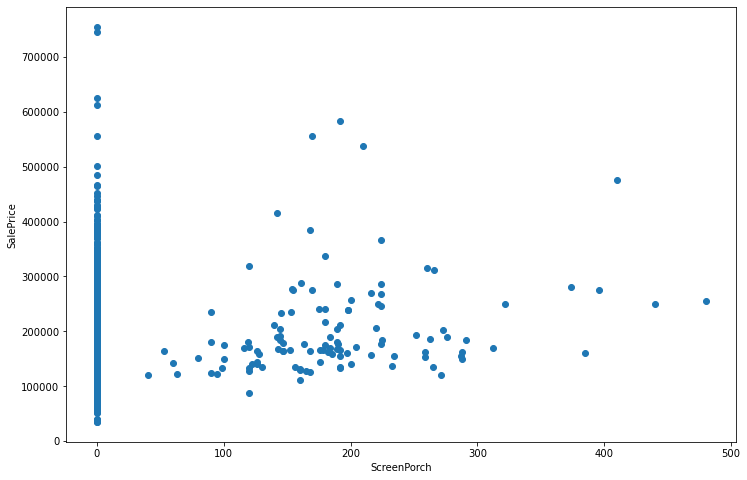

PoolArea 71


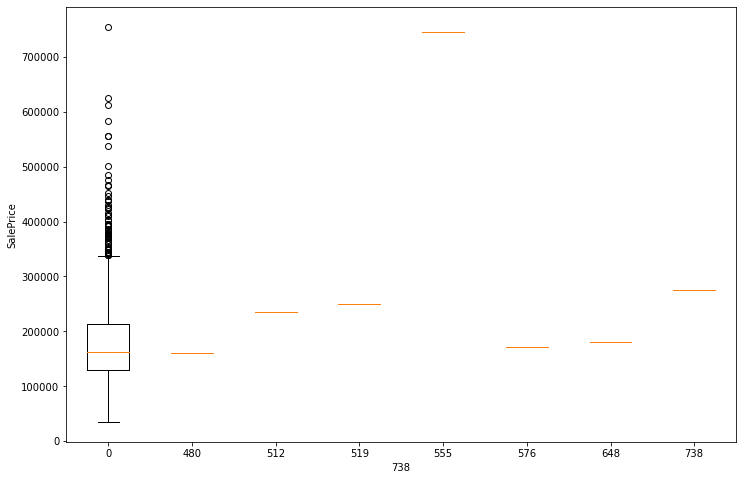

PoolQC 72


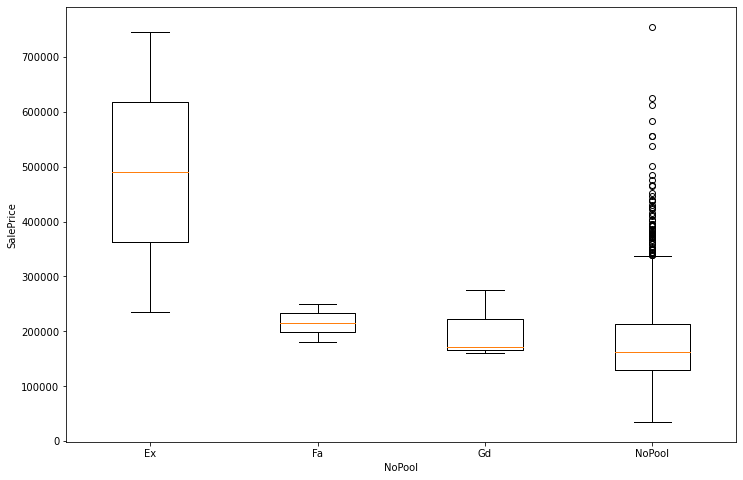

Fence 73


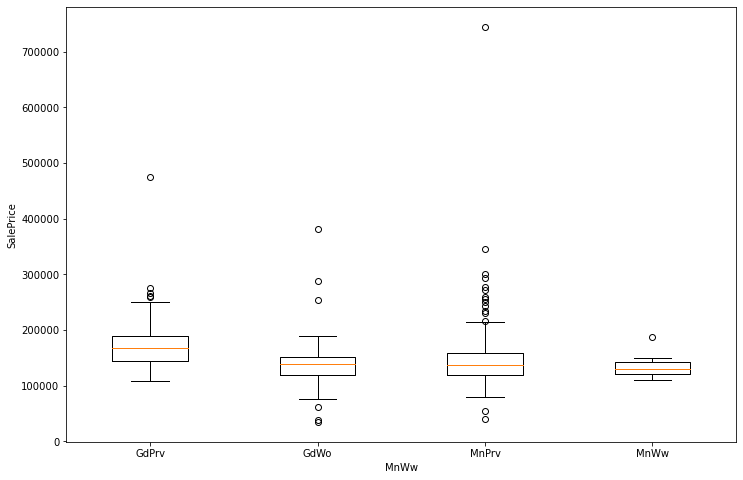

MiscFeature 74


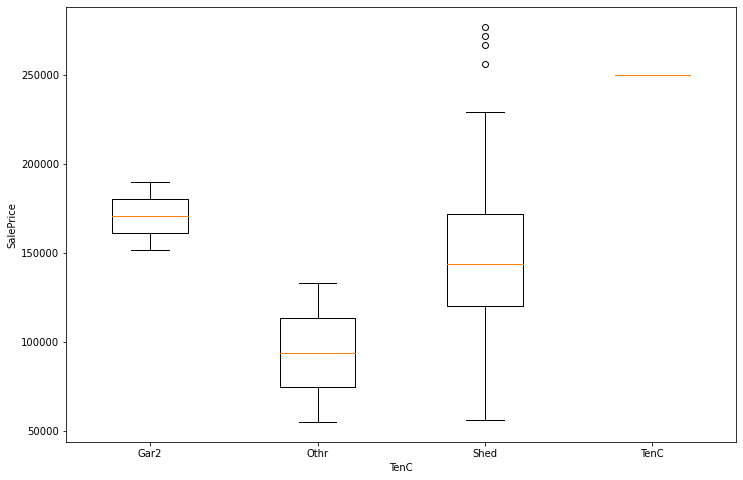

MiscVal 75


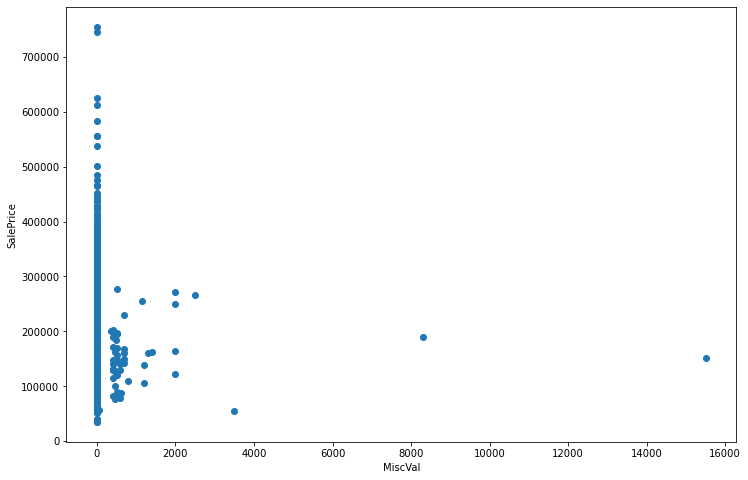

MoSold 76


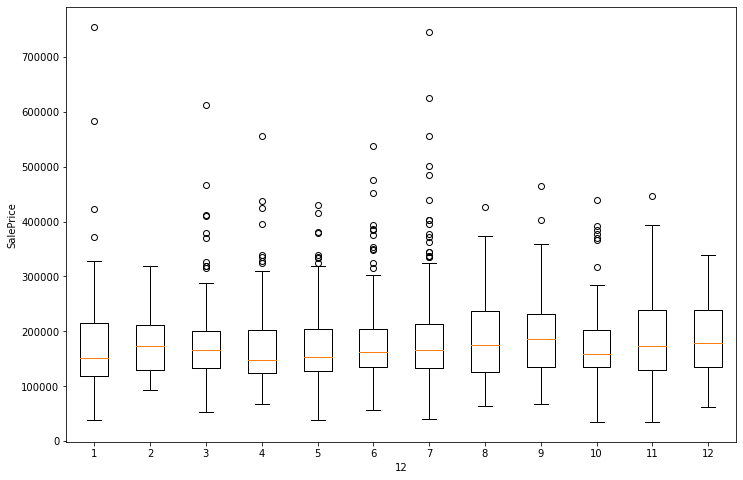

YrSold 77


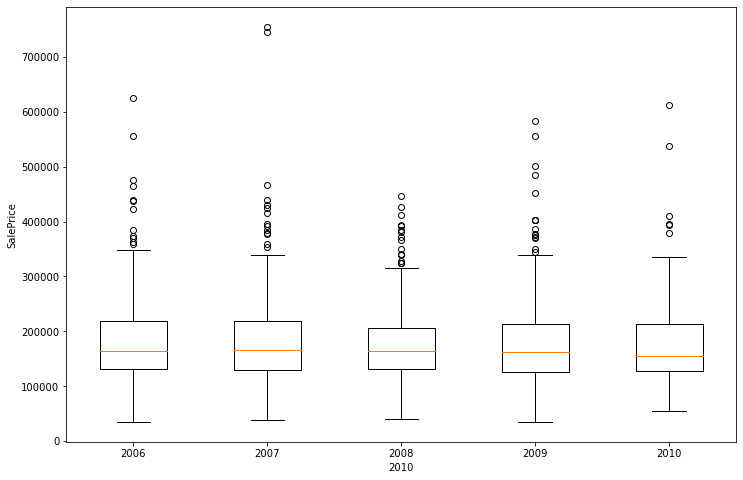

SaleType 78


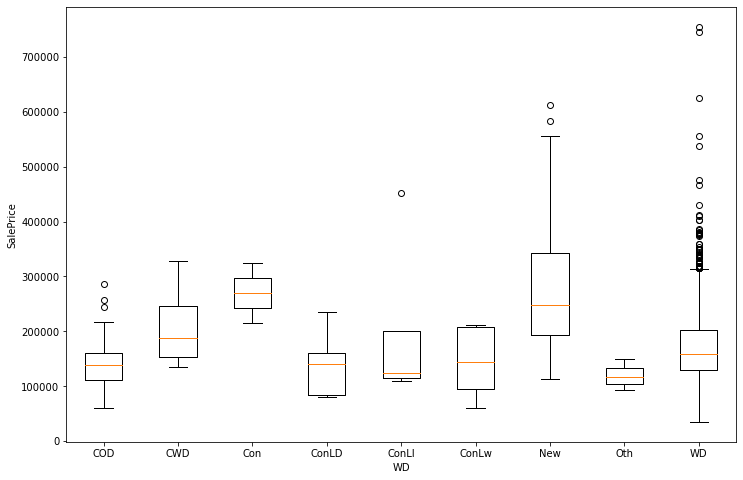

SaleCondition 79


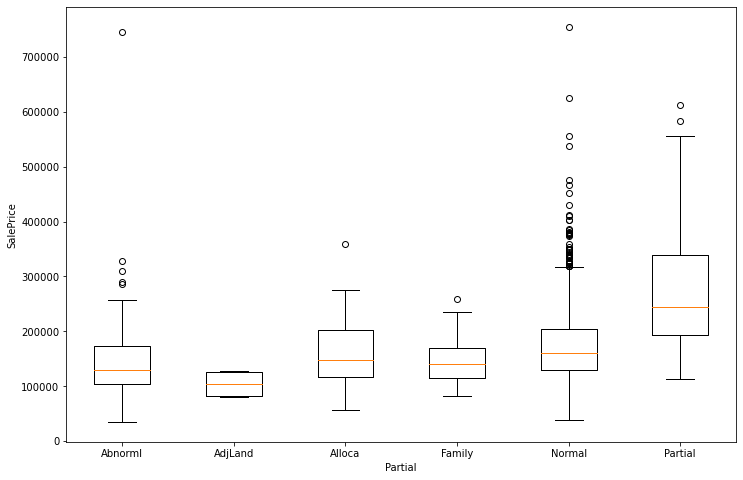

TotFlrSF 80


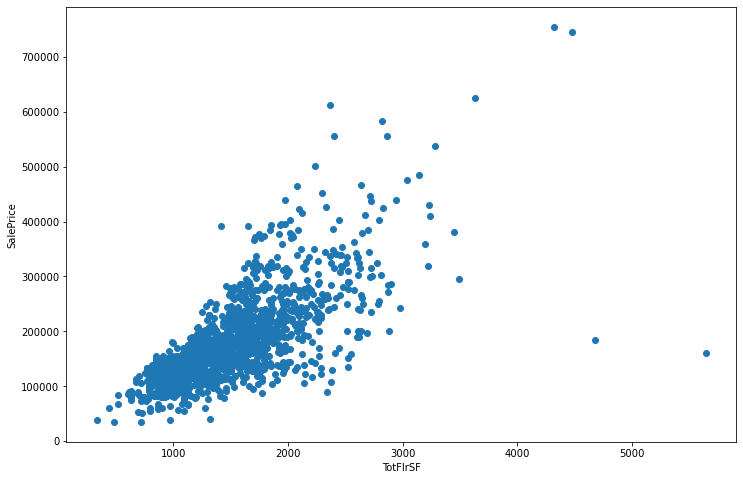

nFlrs 81


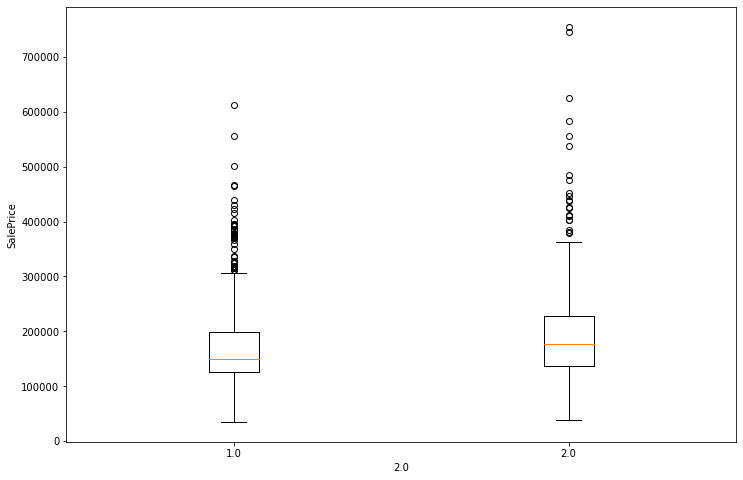

AvgSF 82


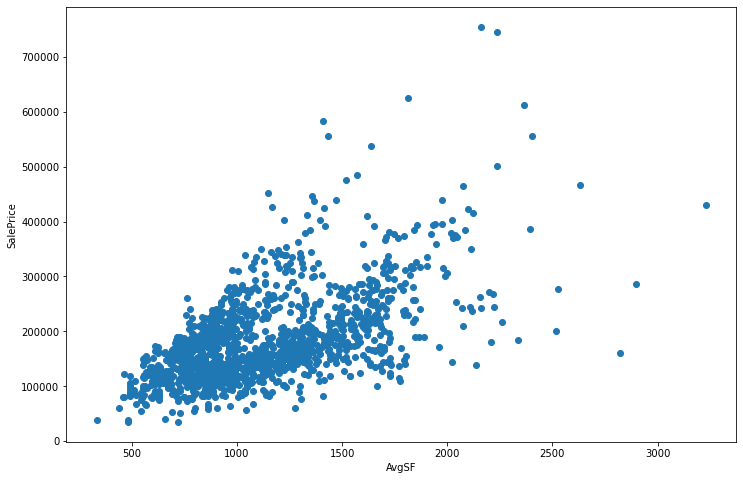

In [63]:
if plot:
    i=0
    for f in features:
        grouped=train.groupby(f)
        if len(grouped.groups)>=20:
            print(f,i)
            i+=1
            fig=plt.figure(figsize=(12,8))
            plt.scatter(train[f],train[label])
            plt.xlabel(f)
            plt.ylabel(label)
            plt.show()
        else:
            print(f,i)
            i+=1
            plot_categorical(grouped,label=label)
    '''    else:
            fig=plt.figure(12,8)
            plt.scatter(train[f],train[label])'''

Let's see if we can do some feature engineering.

First: find if there are nan entries:

In [64]:
subset_df = test.loc[:, train.isnull().any()]

subset_df

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageYrBlt,GarageFinish,Fence,MiscFeature
0,80.0,NaN,None,0.0,TA,TA,No,Rec,LwQ,SBrkr,1961.0,Unf,MnPrv,NaN
1,81.0,NaN,BrkFace,108.0,TA,TA,No,ALQ,Unf,SBrkr,1958.0,Unf,NaN,Gar2
2,74.0,NaN,None,0.0,Gd,TA,No,GLQ,Unf,SBrkr,1997.0,Fin,MnPrv,NaN
3,78.0,NaN,BrkFace,20.0,TA,TA,No,GLQ,Unf,SBrkr,1998.0,Fin,NaN,NaN
4,43.0,NaN,None,0.0,Gd,TA,No,ALQ,Unf,SBrkr,1992.0,RFn,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,NaN,None,0.0,TA,TA,No,Unf,Unf,SBrkr,NaN,NaN,NaN,NaN
1455,21.0,NaN,None,0.0,TA,TA,No,Rec,Unf,SBrkr,1970.0,Unf,NaN,NaN
1456,160.0,NaN,None,0.0,TA,TA,No,ALQ,Unf,SBrkr,1960.0,Unf,NaN,NaN
1457,62.0,NaN,None,0.0,Gd,TA,Av,GLQ,Unf,SBrkr,NaN,NaN,MnPrv,Shed


In [65]:
def count_na_per_col(df):
    count=df.isna().sum()
    count=pd.DataFrame(count).T
    return count

In [66]:
count_na_per_col(train).append(count_na_per_col(test))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs,AvgSF,synth
0,0,0,0,259,0,0,1369,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0.0
0,0,0,4,227,0,0,1352,0,0,2,...,0,0,0,1,0,NaN,0,0,0,NaN


#### Selecting the interesting features

In [67]:
int_cat_f=['SaleCondition','TotRmsAbvGrd','ExterQual','Exterior1st','Neighborhood',
            'GarageFinish','KitchenQual','SaleType','PoolQC', 'OverallCond',
            'FullBath','HouseStyle','Condition1','MSZoning','BldgType','BsmtQual']
int_num_f=['LotArea','LotFrontage','BsmtFinSF1','TotalBsmtSF',
            'GrLivArea','GarageYrBlt','GarageArea','YearBuilt','MSSubClass']
int_ord_f=['GarageCars','OverallQual']

## Beginning regressions

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import set_config
from sklearn.metrics import r2_score,make_scorer,mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor


In [69]:
#try using keras model in scikit pipeline.. or just do it all in tensorflow/keras?
#from keras.wrappers.scikit_learn import KerasRegressor

In [70]:
params = [{'regressor': [GradientBoostingRegressor()],
 'regressor__learning_rate': [0.03,0.1, 0.5, 1.0],
 'regressor__n_estimators' : [25,50, 100, 150,200]
 },
 {
    'regressor':[RandomForestRegressor()],
    'regressor__n_estimators' : [25,50, 100, 150,200]
 },
 {
   'regressor':[AdaBoostRegressor()],
   'regressor__learning_rate':[0.03,0.1, 0.5, 1.0],
   'regressor__n_estimators' : [25,50, 100, 150,200],
   'regressor__loss':['linear','square']
 }
 ]

https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search

In [71]:
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_transformer = Pipeline(steps=[
    ('inp',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

binned_transformer = Pipeline(steps=[('inp',SimpleImputer(strategy='median')),
                                    ('KBinsDiscretizer',KBinsDiscretizer(n_bins=10))])

ordinal_transformer = Pipeline(steps=[
    ('ordenc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, int_num_f),
        ('cat', categorical_transformer, int_cat_f),
        ('ord', ordinal_transformer, int_ord_f)
        ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

In [72]:
def pipeline_builder(n_cols,c_cols,o_cols,b_cols):
    numeric_transformer = Pipeline(steps=[
        ('inp',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    binned_transformer = Pipeline(steps=[('inp',SimpleImputer(strategy='median')),
                                    ('KBinsDiscretizer',KBinsDiscretizer(n_bins=10))])
    ordinal_transformer = Pipeline(steps=[('onehot', OrdinalEncoder())])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, n_cols),
        ('cat', categorical_transformer, c_cols),
        ('ord', ordinal_transformer, o_cols),
        ('bin',binned_transformer, b_cols)
        ])
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])
    pipeline
    return pipeline

In [73]:
score = make_scorer(r2_score)

gridsearch=GridSearchCV(verbose=1,estimator=pipeline,param_grid=params,scoring=score,return_train_score=False,cv=3)


In [74]:

#
x,y=train.drop(label,axis=1),train[label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)


In [75]:
set_config(display='diagram')
gridsearch

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('inp',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'BsmtFinSF1',
                                                                          'TotalBsmtSF',
                                                                          'GrLivArea',
                                                                          'GarageYrBlt',
                                                                          'GarageArea',
                                                                          'YearBuilt',
                                                                          'MSSubClass']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder...
                          'regressor__learning_rate': [0.03, 0.1, 0.5, 1.0],
                          'regressor__n_estimators': [25, 50, 100, 150, 200]},
                         {'regressor': [RandomForestRegressor()],
                          'regressor__n_estimators': [25, 50, 100, 150, 200]},
                         {'regressor': [AdaBoostRegressor()],
                          'regressor__learning_rate': [0.03, 0.1, 0.5, 1.0],
                          'regressor__loss': ['linear', 'square'],
                          'regressor__n_estimators': [25, 50, 100, 150, 200]}],
             scoring=make_scorer(r2_score), verbose=1)

In [76]:
model1=gridsearch.fit(x_train,(y_train))

Fitting 3 folds for each of 65 candidates, totalling 195 fits


In [77]:
#model1.cv_results_

In [78]:
model1.best_score_

0.8572890959277687

In [79]:
model1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('inp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'BsmtFinSF1', 'TotalBsmtSF',
                                                   'GrLivArea', 'GarageYrBlt',
                                                   'GarageArea', 'YearBuilt',
                                                   'MSSubClass']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))])...
                                                   'Exterior1st',
                                                   'Neighborhood',
                                                   'GarageFinish',
                                                   'KitchenQual', 'SaleType',
                                                   'PoolQC', 'OverallCond',
                                                   'FullBath', 'HouseStyle',
                                                   'Condition1', 'MSZoning',
                                                   'BldgType', 'BsmtQual']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordenc',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['GarageCars',
                                                   'OverallQual'])])),
                ('regressor', GradientBoostingRegressor(n_estimators=200))])

In [80]:
import datetime

In [81]:
savemodel=True

In [82]:
if savemodel:
    timestamp=datetime.datetime.now().strftime("%d%m%Y%H%M%S")
    models_folder= 'models'
    os.makedirs(models_folder,exist_ok=True)
    model_name= 'model_'+ timestamp +'.joblib'
    modelpath= os.path.join(models_folder,model_name)
    from joblib import dump, load
    dump(model1, modelpath)
    print('Saved ' , modelpath)

Saved  models\model_09112022182415.joblib


In [83]:
def score_and_visualize(model,x_test,y_test):
    predictions=model.predict(x_test)
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    msle=mean_squared_log_error(y_true=y_test, y_pred=predictions)#msle is the metric evaluated in the kaggle challange
    r2=r2_score(y_true=y_test, y_pred=predictions)
    print('r2 coefficient: ',r2,'\nmsle = ', msle)
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.axline((0,0),slope=1,ls='--')
    plt.show()

In [84]:
#len(model2[1].feature_importances_)

In [85]:
print(y_test)

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
271     241500
445     127500
654     350000
1280    227000
898     611657
Name: SalePrice, Length: 438, dtype: int64


r2 coefficient:  0.8416684408965422 
msle =  0.01664250866218893


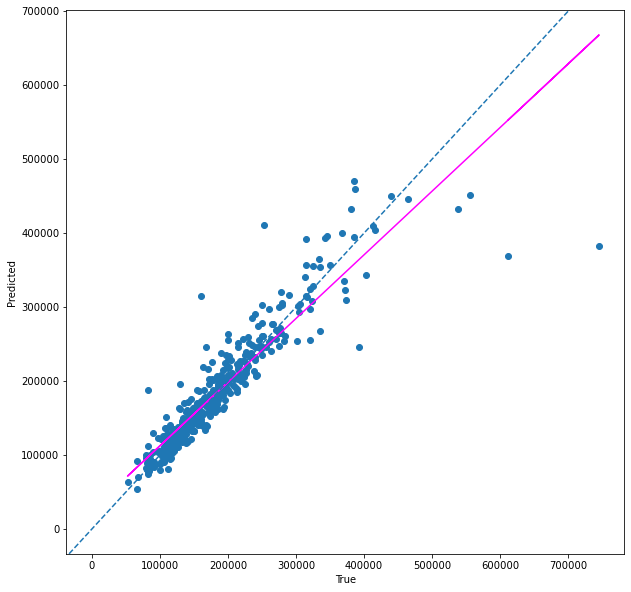

In [86]:
score_and_visualize(model=model1,x_test=x_test,y_test=y_test)
#score_and_visualize(model=model2,x_test=x_test,y_test=y_test)

## Now make predictions on the test dataset

In [87]:
sample_sub=pd.read_csv('sample_submission.csv')
sample_sub

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


### Make prediction and save

In [88]:
#make prediction on the test set and save
pred=model1.predict(test)


In [89]:
write=True

In [90]:
out_df=pd.read_csv('sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction.csv',index=False)